#  Multimodal Source Decomposition on Realistic fNIRS-EEG Data with Synthetic Ground Truth

In this example notebook we apply a set of source decomposition methods to a realistic fNIRS-EEG data with synthetic groung truth, created for this purpose, and report on their performance. 

We divide the notebook in two parts, the first one contains the synthetic data generation pipeline, step by step. It ends in the creation of a few temporary files that are then used to test the source decomposition methods. In the second part of the notebook we test the source decomposition methods in the data we just created, beginning with some preprocessing steps that bring the "raw" synthetic data to a suitable format for the method's inputs.

In [ ]:
# This cells setups the environment when executed in Google Colab.
try:
    import google.colab
    !curl -s https://raw.githubusercontent.com/ibs-lab/cedalion/dev/scripts/colab_setup.py -o colab_setup.py
    # Select branch with --branch "branch name" (default is "dev")
    %run colab_setup.py
except ImportError:
    pass

In [1]:
# Import necessary libraries for the entire notebook
import os
import numpy as np
import pandas as pd
import scipy as sp
import xarray as xr
import mne
from mne.decoding import SSD
import pyvista as pv
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.signal import detrend, butter, lfilter, hilbert
from scipy.io import loadmat

import cedalion
import cedalion.datasets
import cedalion.imagereco.forward_model as fw
import cedalion.sigproc.quality as quality
from cedalion.sigproc.frequency import sampling_rate, freq_filter
import cedalion.plots as cp
import cedalion.io as cio
from cedalion.io.probe_geometry import load_tsv
from cedalion.vis import plot_sensitivity_matrix
from cedalion import units
from cedalion.sim.synthetic_hrf import build_spatial_activation, build_stim_df, plot_spatial_activation
import cedalion.models.glm as glm

from sklearn.decomposition import PCA as PCA_sk
from cedalion.sigdecomp.multimodal.cca_models import ElasticNetCCA, StructuredSparseCCA, CCA, RidgeCCA
from cedalion.sigdecomp.multimodal.mspoc import mSPoC
from cedalion.sigdecomp.multimodal.tcca_models import ElasticNetTCCA, StructuredSparseTCCA, tCCA

In [2]:
# Helper function to load required files from cedalion web server

import pooch
from pathlib import Path

DATASETS = pooch.create(
    path=pooch.os_cache("cedalion"),
    base_url="https://doc.ibs.tu-berlin.de/cedalion/datasets",
    registry={
        "multimodal_eeg_fnirs_paper_files.zip": "sha256:08f4fd0c13a790028848ed06803e5d84c33cb83ab7d5de0a0338b949191acbd3",  # noqa: E501
    },
)


def get_paper_files():
    fnames = DATASETS.fetch(
        "multimodal_eeg_fnirs_paper_files.zip", processor=pooch.Unzip()
    )

    basedir = Path(fnames[0]).parent

    # fmt: off
    files = {
        "BACKGROUND_fNIRS_DIR": str(basedir / "fnirs_colocalized_raw.nc"),
        "BACKGROUND_EEG_DIR":   str(basedir / "eeg_colocalized_raw.fif"),
        "MONTAGE_DIR":          str(basedir / "montage_bilateral_colocalized.tsv"),
        "MEASLIST_DIR":         str(basedir / "meas_list_bilateral_colocalized.csv"),
        "SENSITIVITY_DIR":      str(basedir / "sensitivity_bilateral_colocalized.nc"),
        "LEADFIELD_DIR":        str(basedir / "lf_simbio_7996_nirfasterVol_colocalized.mat"),
    }
    # fmt: on

    return basedir, files

## Synthetic data

In this section we walk trhough the pipeline for generating a realistic fNIRS-EEG data with synthetic ground truth. The resulting dataset comprises biologically plausible EEG-fNIRS neural activity, ensuring shared spatiotemporal co-modulation between sources, localized in the primary motor cortex, via simultaneous EEG alpha-band suppression and oxygenated hemoglobin increase in fNIRS. The simulated neural activity sits on top of a real concurrent HD-fNIRS-EEG recording from a single subject at rest, providing correlation between underlying processes already at noise level. 

In [3]:
# Directories
basedir, files = get_paper_files()
BACKGROUND_fNIRS_DIR = files["BACKGROUND_fNIRS_DIR"]
BACKGROUND_EEG_DIR = files["BACKGROUND_EEG_DIR"]
MONTAGE_DIR = files["MONTAGE_DIR"]
MEASLIST_DIR = files["MEASLIST_DIR"]
SENSITIVITY_DIR = files["SENSITIVITY_DIR"]
LEADFIELD_DIR = files["LEADFIELD_DIR"]

In [4]:
# To store temporal variables and datasets
TMP_DIR = str(basedir / 'tmp')
os.makedirs(TMP_DIR, exist_ok=True)

# Some globabl parameters 
source_location_landmark = 'C3' # Left motor cortex
source_freq = (8, 12) # Alpha band

### Background Data

To produce realistic background noise underlying the simulated experiment, we collected five minutes of real concurrent HD-fNIRS-EEG resting state data from a single subject.

#### Data Loading

In [5]:
# Load fNIRS background data
fnirs_bg = xr.load_dataarray(BACKGROUND_fNIRS_DIR) 
wl1, wl2 = fnirs_bg.wavelength.data

# Load EEG and EOG background data
electrodes_bg = mne.io.read_raw_fif(BACKGROUND_EEG_DIR, preload=True)

# Store maximum simulation time
T_sim = np.min([float(fnirs_bg.time[-1]), float(electrodes_bg.times[-1])])

Opening raw data file /Users/guybrush/Library/Caches/cedalion/multimodal_eeg_fnirs_paper_files.zip.unzip/eeg_colocalized_raw.fif...
    Range : 26000 ... 176002 =     51.999 ...   352.000 secs
Ready.
Reading 0 ... 150002  =      0.000 ...   300.001 secs...


#### Montage and measurement list

The fNIRS dataset comprises optical-density (OD) recordings at two wavelengths (760nm and 850nm) across 100 measurement channels, created by pairings of 14 light sources and 32 detectors arranged in a bilateral high-density hexagonal grid over the motor cortex, with source–detector separations of 19mm and 33mm. EEG data represents electrical activity collected from the 32-channel actiCAP arrangement. fNIRS data was recorded by two NIRSport2 devices (NIRx GmbH, Berlin, Germany) at 12.6 Hz sampling rate. EEG data was collected using a 32-channel LiveAmp amplifier (Brain Products GmbH, Gilching, Germany) with active Ag/AgCl electrodes mounted in the NinjaCap following the actiCAP arrangement. The sites normally occupied by FT9, FT10, T7, and T8 were repurposed to record horizontal and vertical EOG channels.

In [6]:
# Load montage
montage = load_tsv(tsv_fname=MONTAGE_DIR, crs=None, units=None)
# Load measurement list
meas_list = pd.read_csv(MEASLIST_DIR, sep=',', index_col=0)
n_channels_fnirs = len(meas_list)//2
channels_fnirs = meas_list['channel'].to_numpy()[:n_channels_fnirs]

#### Small preprocessing on fNIRS background data

We now perform a small preprocessing on the background data, required before adding the synthetic stimuli on top. This includes channel prunning via SCI and PSP quality metrics, convertion to OD, and detrending.

In [7]:
## Channel prunning

# Calculate masks for SCI and PSP quality metrics
window_length = 5 * units.s
sci_thresh = 0.75
psp_thresh = 0.1
sci_psp_percentage_thresh = 0.75

sci, sci_mask = quality.sci(fnirs_bg, window_length, sci_thresh)
psp, psp_mask = quality.psp(fnirs_bg, window_length, psp_thresh)
sci_x_psp_mask = sci_mask & psp_mask
perc_time_clean = sci_x_psp_mask.sum(dim="time") / len(sci.time)
sci_psp_mask = [perc_time_clean >= sci_psp_percentage_thresh]

# Prune channels that do not pass at least one of the quality test
fnirs_bg_pruned, drop_list = quality.prune_ch(fnirs_bg, sci_psp_mask, "all")

# Display pruned channels and resulting clean signal
print(f"List of pruned channels: {drop_list}  ({len(drop_list)})")

## Convert to OD
fnirs_bg_od = cedalion.nirs.int2od(fnirs_bg_pruned)

## Detrend
fnirs_bg_detrended = fnirs_bg_od.copy()
fnirs_bg_detrended.data = detrend(fnirs_bg_detrended.data, axis=2, type='linear')

## Final clean version of brackground data
fnirs_bg_preprocessed = fnirs_bg_detrended.copy()

## Store sampling rate and channel names
fnirs_bg_rate = sampling_rate(fnirs_bg_preprocessed.time).magnitude
fnirs_bg_channels = fnirs_bg_preprocessed.channel.values

List of pruned channels: ['S1D6' 'S3D2' 'S3D13' 'S5D8' 'S6D8' 'S7D7' 'S7D14' 'S11D23' 'S11D32'
 'S12D24' 'S12D31' 'S14D23' 'S14D29']  (13)


##### Visualize preprocessed fNIRS data

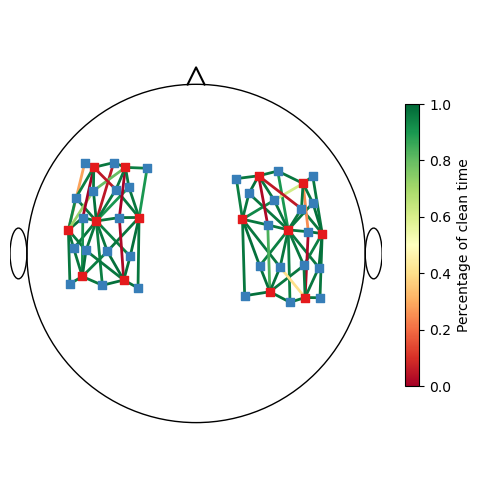

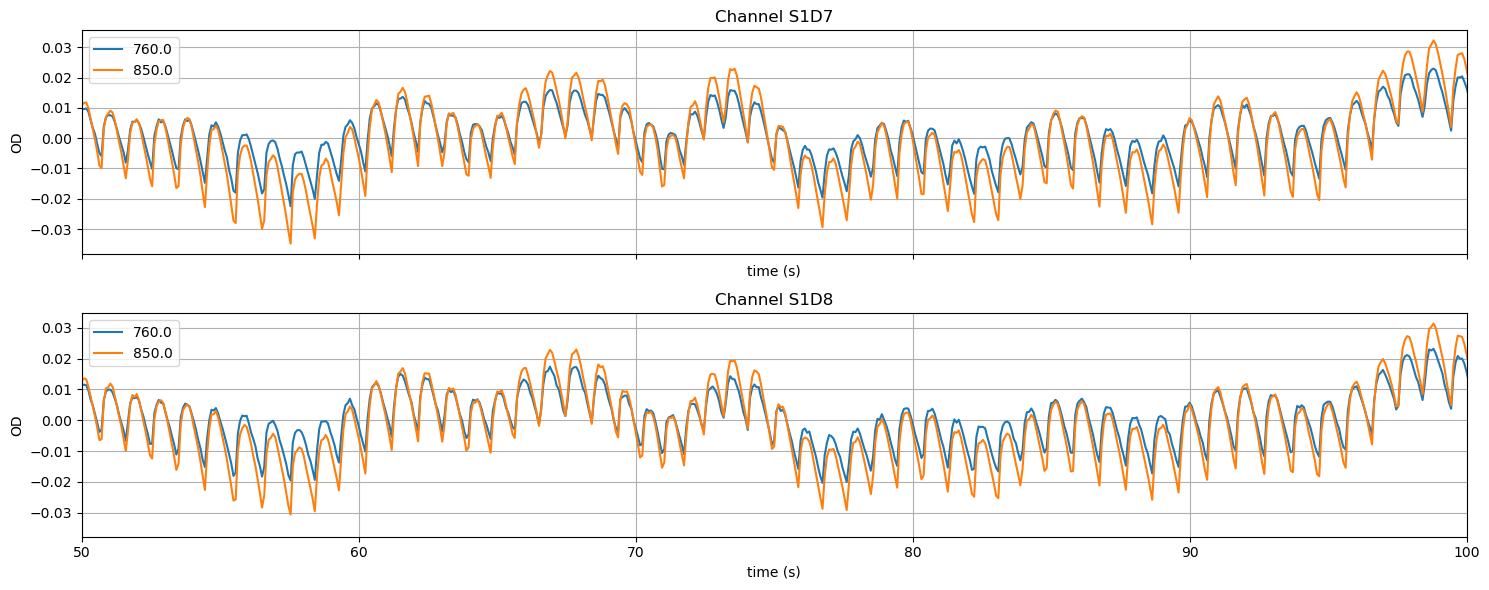

In [8]:
# Plot the percentage of clean time per channel
f, ax = plt.subplots(1, 1, figsize=(5,5))

cedalion.plots.scalp_plot(
    fnirs_bg,
    montage,
    perc_time_clean,
    ax,
    cmap="RdYlGn",
    vmin=0,
    vmax=1,
    title=None,
    cb_label="Percentage of clean time",
    channel_lw=2
)
f.tight_layout()

# Plot timeseries of the clean data
fnirs_ch_to_plot = ['S1D7', 'S1D8'] # [c for c in fnirs_bg_preprocessed.channel.values if 'S1D' in c]
f, ax = plt.subplots(len(fnirs_ch_to_plot), 1, figsize=(15, 3*len(fnirs_ch_to_plot)), sharex=True)

for i, c in enumerate(fnirs_ch_to_plot):
    ax[i].plot(fnirs_bg_preprocessed.time, fnirs_bg_preprocessed.sel(channel=c, wavelength=wl1), label=wl1)
    ax[i].plot(fnirs_bg_preprocessed.time, fnirs_bg_preprocessed.sel(channel=c, wavelength=wl2), label=wl2)
    ax[i].set_title(f"Channel {c}")
    ax[i].legend()
    ax[i].set_xlabel("time (s)")
    ax[i].set_ylabel("OD")
    ax[i].grid()

plt.xlim(50, 100)
plt.tight_layout()
plt.show()

In [9]:
# Once satisfied with the preprocessing, save background data for later use
fnirs_bg_preprocessed.to_netcdf(os.path.join(TMP_DIR, "fnirs_bg_preprocessed.nc"))

#### Small preprocessing on EEG and EOG background data

We now perform a small preprocessing on the EEG and EOG background data. We begin with some temporal preprocessing, including detrending, band-pass filtering, and subsampling. We then follow with the identification of bad channels and their interpolation using information from the remaining "good" channels, together with average rereferencing. Finally, we remove as much alpha motor activity from EEG data as possible so true sources do not interfere with our synthetically generated ones. To this end, we use the spatio-spectral decomposition (SSD) algorithm (Nikulin et al., 2011) to identify alpha-band neural oscillations and remove the components whose highest activity lay in the left-motor region.

In [10]:
def find_nearest_neighbor_channels(data, channel):
    """
    Find the nearest neighbor channel to the target channel.
    """
    
    all_channels = data.info['chs']
    ch_pos = [c['loc'][:3] for c in all_channels if c['ch_name']==channel][0]
    
    # Compute Euclidean distance between the target and each other channel.
    distances = {}
    for ch in all_channels:
        ch_name = ch['ch_name']
        if ch_name == channel:
            continue
        pos = ch['loc'][:3]
        
        # Check position has right format
        if pos is None or len(pos) < 3:
            raise ValueError('Position with wrong format found...')
            
        dist = np.linalg.norm(np.array(pos) - np.array(ch_pos))
        distances[ch_name] = dist
    
    # Identify the channels with the smallest distance.
    min_dist = min(distances.values())
    
    nearest_channels = [k for k, v in distances.items() if np.isclose(v, min_dist, rtol=1e-1)]   
    nearest_channels += [channel]
    
    return nearest_channels, min_dist

def remove_sources(data, target_channels, freqs_sig, step=1, only_target=False):
    """
    Decompose data into components, recognize those sources that are most similar to the ones
    we want to add synthetically and subtract them.
    """

    freqs_noise = [freqs_sig[0] - step, freqs_sig[1] + step]

    # Initialize SSD algorithm
    ssd = SSD(
        info=data.info,
        reg="oas",
        sort_by_spectral_ratio=True,
        filt_params_signal=dict(
            l_freq=freqs_sig[0],
            h_freq=freqs_sig[1],
            l_trans_bandwidth=1,
            h_trans_bandwidth=1,
        ),
        filt_params_noise=dict(
            l_freq=freqs_noise[0],
            h_freq=freqs_noise[1],
            l_trans_bandwidth=1,
            h_trans_bandwidth=1,
        ),
    )

    # Fit
    ssd.fit(X=data.get_data())
    # Transform
    ssd_sources = ssd.transform(X=data.get_data())
    # Get spatial patterns (invers of filtes)
    patterns = ssd.patterns_

    data_subtracted = data.copy()
    for t_ch in target_channels:
        # Get nearest channels to the target source
        nearest_channels, _ = find_nearest_neighbor_channels(data, t_ch)

        # Get indices of patterns whose highest activity is located at the nearest channels
        relevant_pattern_ndx = []
        for i, max_ndx in enumerate(np.argmax(patterns, axis=1)):
            max_ch = data.info['chs'][max_ndx]['ch_name']
            if only_target:
                if max_ch == t_ch:
                    relevant_pattern_ndx.append(i)
            else:
                if max_ch in nearest_channels:
                    relevant_pattern_ndx.append(i)

        if not len(relevant_pattern_ndx):
            print(f"No source found with highest-activty in the neighbourhood of {t_ch}\n")
            print(f"We therefore omit the subtraction for this channel...")
            continue

        # Build reconstructed signal from selected sources
        reconstructed_ssd = patterns[relevant_pattern_ndx].T @ ssd_sources[relevant_pattern_ndx]

        # Subtract reconstructed source from original data
        data_subtracted._data = data_subtracted.get_data() - reconstructed_ssd

    return data_subtracted

In [11]:
electrodes_bg_tmp = electrodes_bg.copy()

# Define frequency band of interest
l_freq = 0.1  # Low cut-off frequency in Hz
h_freq = 45  # High cut-off frequency in Hz
new_freq = 100  # New sampling frequency in Hz

# Detrend
electrodes_bg_tmp._data = mne.filter.detrend(electrodes_bg_tmp.get_data(), order=1)
# Apply band-pass filtering and detrending
electrodes_bg_tmp.filter(l_freq=l_freq, h_freq=h_freq, method='fir', phase='zero')
# Dowsample
electrodes_bg_tmp.resample(new_freq)

# Mark bad channels
electrodes_bg_preprocessed_ch = electrodes_bg_tmp.copy()
bad_channels = ['C4', 'P4', 'P8', 'P7', 'O1', 'CP5', 'O2', 'C3']  # Selected manually via prior visualization
electrodes_bg_preprocessed_ch.info['bads'] = bad_channels
# Interpolate
electrodes_bg_preprocessed_ch.interpolate_bads(reset_bads=True); # Reset_bad=true remove bad-channel labels from interpolated channels

# Re-reference data via average
electrodes_bg_preprocessed_ref = electrodes_bg_preprocessed_ch.copy()
electrodes_bg_preprocessed_ref.set_eeg_reference('average', projection=True)
electrodes_bg_preprocessed_ref.apply_proj()

# Split preprocessed data into EEG and EOG
eeg_bg_preprocessed = electrodes_bg_preprocessed_ref.copy().pick(picks=['eeg'])
eog = electrodes_bg_preprocessed_ref.copy().pick(picks=['eog'])

# Remove sources already present in the background data in the same frequency and location to our synthetic source
eeg_bg_preprocessed = remove_sources(eeg_bg_preprocessed, [source_location_landmark], freqs_sig=source_freq)

# Convert to xarrays
eeg_bg_preprocessed_xr = xr.DataArray(data=eeg_bg_preprocessed._data, 
                      coords={'channel': eeg_bg_preprocessed.ch_names, 'time': eeg_bg_preprocessed.times})
eeg_bg_preprocessed_xr = eeg_bg_preprocessed_xr.assign_coords({'time': eeg_bg_preprocessed_xr.time.assign_attrs({'units': units.s}),
                                                               'samples': ('time', np.arange(0, len(eeg_bg_preprocessed_xr.time)))})

eog = xr.DataArray(eog._data, 
                   dims=["channel", "time"],
                   coords={"channel": eog.info['ch_names'],
                           'time': eog.times,
                           'samples': ('time', np.arange(0, len(eog.times)))})

# Store sampling rate and channel names
eeg_bg_rate = sampling_rate(eeg_bg_preprocessed_xr.time).magnitude
eeg_bg_channels = eeg_bg_preprocessed_xr.channel.values

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 16501 samples (33.002 s)

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 20 sensor positions
Interpolating 8 sensors
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to ap

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    0.0s finished


Estimating covariance using OAS
Done.
Estimating covariance using OAS
Done.
Computing rank from covariance with rank=None
    Using tolerance 0.0022 (2.2e-16 eps * 28 dim * 3.6e+11  max singular value)
    Estimated rank (eeg): 27
    EEG: rank 27 computed from 28 data channels with 1 projector
Computing rank from covariance with rank=None
    Using tolerance 0.00053 (2.2e-16 eps * 28 dim * 8.5e+10  max singular value)
    Estimated rank (eeg): 27
    EEG: rank 27 computed from 28 data channels with 1 projector
Projecting covariance of 28 channels to 27 rank subspace
Effective window size : 1.000 (s)
Done.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


##### Visualize preprocessed EEG data

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 20.480 (s)
Plotting power spectral density (dB=True).
Using matplotlib as 2D backend.


/opt/anaconda3/envs/cedalion/lib/python3.11/site-packages/mne/viz/utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


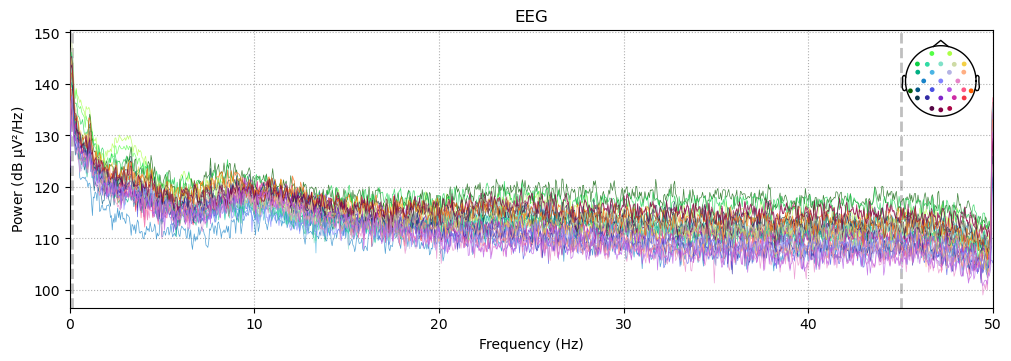

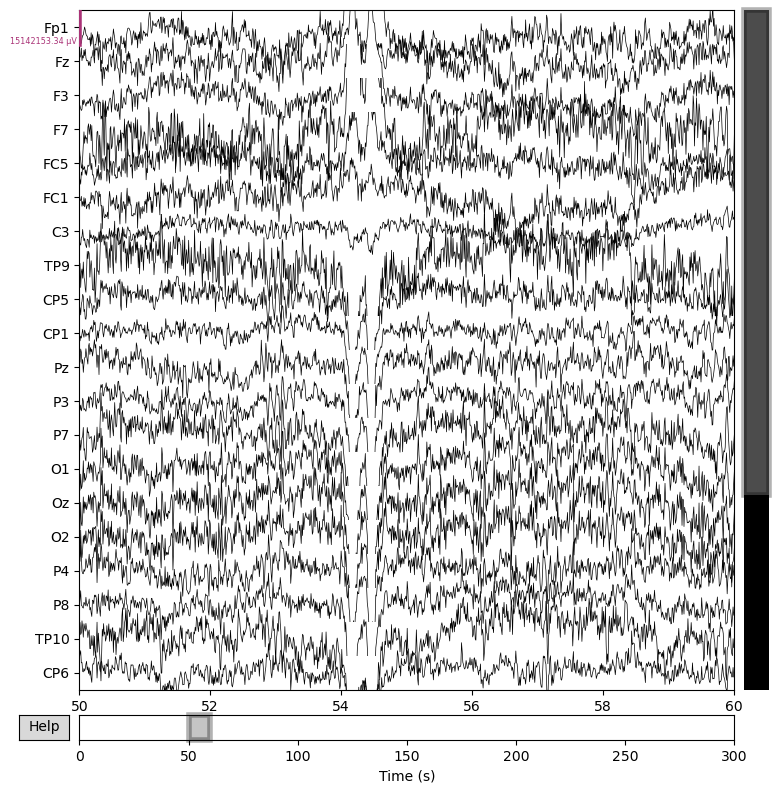

In [12]:
eeg_bg_preprocessed.plot_psd(fmin=0, fmax=50)
eeg_bg_preprocessed.plot(start=50, duration=10, scalings='auto', show=True);


In [13]:
# When satisfied with the preprocessing, save background data for later use
eeg_bg_preprocessed_xr = eeg_bg_preprocessed_xr.assign_coords({'time': eeg_bg_preprocessed_xr.time.pint.dequantify()})
eeg_bg_preprocessed_xr.to_netcdf(os.path.join(TMP_DIR, "eeg_bg_preprocessed.nc"))
eog.to_netcdf(os.path.join(TMP_DIR, "eog.nc"))

### Source spatial profiles

We now build the spatial profiles for the simulated sources. The end-result of this step are the mixing matrices for fNIRS and EEG forward models.

#### Headmodel 

The source spatial profiles share the same head model of the anatomy of Colin27, segmentation masks (gray/white matter, air, CSF, bone, and skin surfaces), FEM volume mesh, and source location. The latter was chosen to be the point in the brain surface closest to the C3 landmark on the scalp. 

In [14]:
# load paths to segmentation data for the Colin27 atlas
SEG_DIR, mask_files, landmarks_file = cedalion.datasets.get_colin27_segmentation()

head = fw.TwoSurfaceHeadModel.from_segmentation(
            segmentation_dir=SEG_DIR,
            mask_files = mask_files,
            landmarks_ras_file=landmarks_file,
            brain_face_count=180000,
            scalp_face_count=60000,
            smoothing=0.5,
            fill_holes=True,
        )

# Set correct units
head.brain.units = units.mm
head.scalp.units = units.mm
head.landmarks = head.landmarks.pint.dequantify()
head.landmarks.pint.units = units.mm

# Build surfaces for eeg forward model
head_eeg = fw.TwoSurfaceHeadModel.from_segmentation(
            segmentation_dir=SEG_DIR,
            mask_files = mask_files,
            landmarks_ras_file=landmarks_file,
            brain_face_count=7996,
            scalp_face_count=60000,
            smoothing=0.5,
            fill_holes=True,
        )

dipoles = head_eeg.brain.vertices
orientations = head_eeg.brain.mesh.vertex_normals


In [15]:
# Align headmodel with montage
# montage = head.align_and_snap_to_scalp(montage)

# Visualize headmodel with montage
plt_pv = pv.Plotter()
cp.plot_surface(plt_pv, head.brain, color="#d3a6a1")
cp.plot_surface(plt_pv, head.scalp, opacity=.1)
cp.plot_labeled_points(plt_pv, montage, show_labels=True)
plt_pv.show()

Widget(value='<iframe src="http://localhost:61093/index.html?ui=P_0x367a6b950_0&reconnect=auto" class="pyvista…

#### Sensitivity matrix

The sensitivity matrix is calculated via photon simulation using NIRFASTer (Dehghani et al., 2009) within Cedalion.

In [16]:
# Calculate or load sensitivity matrix
LOAD_SENSITIVITY = True

if LOAD_SENSITIVITY:
    print("Loading sensitivity...")
    sensitivity = cio.forward_model.load_Adot(SENSITIVITY_DIR)
    if 'source' not in sensitivity.coords._names:
        source = [d.split('D')[0] for d in sensitivity.channel.data]
        sensitivity = sensitivity.assign_coords({'source': ('channel', source)})
    if 'detector' not in sensitivity.coords._names:
        detector = ['D' + d.split('D')[1] for d in sensitivity.channel.data]
        sensitivity = sensitivity.assign_coords({'detector': ('channel', detector)})
    
else:
    print("Calculating sensitivity matrix...")
    fwm = cedalion.imagereco.forward_model.ForwardModel(head, montage, meas_list)
    fluence_all, fluence_at_optodes = fwm.compute_fluence_nirfaster()
    sensitivity = fwm.compute_sensitivity(fluence_all, fluence_at_optodes)
    # Save
    cio.forward_model.save_Adot(SENSITIVITY_DIR, sensitivity)

# Restrict to only brain vertices, not scalp
sensitivity = sensitivity[:, (sensitivity.is_brain).values,:]

Loading sensitivity...


#### Leadfield matrix

The EEG leadfield is computed with the SimBio FEM solver (Vorwerk et al., 2018) as integrated in the FieldTrip MATLAB toolbox (Oostenveld et al., 2011). Since, MATLAB is required for this step, here we simply load the leadfield file. 

In [17]:
# Load Leadfield matrix
lf_all = loadmat(LEADFIELD_DIR, simplify_cells=True)['lf']
lf_data = lf_all['leadfield']
lf_channel_labels = lf_all['label']

#### Source spatial distributions

For the modality-specific spatial information, we used a single dipole structure for EEG, and for fNIRS we generated a Gaussian-distributed activity mask, both centered around the common source location.

In [18]:
# Find closest brain vertex to landmark and its cortex location
source_location_landmark = 'C3'
source_location = montage.sel(label=source_location_landmark)  # Get coordinates on scalp
# Find closest vertex on brain for fNIRS
seed_vertex_fnirs = head.brain.mesh.kdtree.query(source_location.pint.dequantify())[1]
# Find closest vertex on brain (dipole) for EEG
seed_vertex_eeg = head_eeg.brain.kdtree.query(source_location.pint.dequantify())[1]

In [19]:
# Build fnirs spatial activation
s_spatial_fnirs = build_spatial_activation(head_model=head,
                                           seed_vertex=seed_vertex_fnirs,
                                           spatial_scale= 20 * units.mm,
                                           intensity_scale= 1 * units.micromolar,
                                           hbr_scale=-0.4)
# Visualize activity
plot_spatial_activation(s_spatial_fnirs.sel(chromo='HbO'), brain=head.brain)


/opt/anaconda3/envs/cedalion/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve


Widget(value='<iframe src="http://localhost:61093/index.html?ui=P_0x34f88a5d0_1&reconnect=auto" class="pyvista…

#### Mixing matrices

The previously computed forward matrices are then used to create fNIRS and EEG mixing matrices by combining them with the modality-specific spatial information.

In [20]:
# Build fNIRS mixing matrix
# Stack chromo and vertex directions
s_stacked = fw.stack_flat_vertex(s_spatial_fnirs)

# Compute stacked senstivity via extintion coefficient multiplication
sensitivity_stacked = fw.ForwardModel.compute_stacked_sensitivity(sensitivity)

# Map signal to channel space
A_stacked = sensitivity_stacked @ s_stacked

# Undo stacking of channels in flat_channel dimension
A_fnirs = fw.unstack_flat_channel(A_stacked)
A_fnirs = A_fnirs.pint.dequantify()
A_fnirs.attrs = {}

In [21]:
# Build EEG mixing matrix
A_eeg = lf_data[:, seed_vertex_eeg, :] @ np.array([-0.2412535 ,  0.9619893 , -0.12795832]) # orientations[seed_vertex_eeg, :]  Pick a specific normal for reproducibility, altough it can be easily changed
A_eeg = xr.DataArray(data=A_eeg, 
                     coords={'channel': lf_channel_labels})

Creating RawArray with float64 data, n_channels=32, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


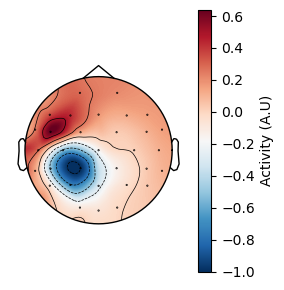

In [22]:
# Visualize EEG mixing matrix as topomap
A = A_eeg.copy()
info = mne.create_info(ch_names=A.channel.data.tolist(), sfreq=100, ch_types=['eeg'] * A.shape[0])
raw = mne.io.RawArray(A.data.reshape(-1, 1), info); 
# Set the electrode layout
raw.set_montage(mne.channels.make_standard_montage('easycap-M1'))

# Normalize
A /= np.abs(A).max()
min_max = (A.min(), A.max())

# Plot
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
im, cn = mne.viz.plot_topomap(A.data, raw.info, axes=ax, show=False, vlim=min_max); 
cax = fig.colorbar(im, ax=ax)
cax.set_label(r'Activity (A.U)')
# Adjust layout
plt.tight_layout()
plt.show()

In [23]:
# Save mixing matrices for later use
A_fnirs.to_netcdf(os.path.join(TMP_DIR,'A_fnirs.nc'))
A_eeg.to_netcdf(os.path.join(TMP_DIR,'A_eeg.nc'))

### Source temporal profiles

We now build the temporal profiles for the simulated sources. The end-result of this step are the time courses of the fNIRS and EEG sources we want to reconstruct.

#### Experiment stimuli simulation

The simulated experiment consists of one single block composed of approximately 12 trials, each of which begins with a 10-second stimulus period followed by a recovery period whose duration is randomly chosen between 8 and 16 seconds. Each trial is assigned a randomly generated "value", that is later used to scale the increase in the fNIRS HRF and the decrease in the EEG alpha bandpower (ERD).

In [24]:
# Build experimental stimuli
def simulate_experiment_markers(T_stim, T_rest_min, T_rest_max, stim_amp_min, stim_amp_max, source_location_landmark):
        """ Simulate experiment markers.
        """

        stim = build_stim_df(
                max_time= T_sim * units.seconds,
                trial_types=[source_location_landmark],
                min_interval=T_rest_min * units.s,
                max_interval=T_rest_max * units.s,
                min_stim_dur=T_stim * units.s,
                max_stim_dur=T_stim * units.s,
                min_stim_value=stim_amp_min,
                max_stim_value=stim_amp_max,
                order="random",
                )

        # Build derived quantities
        simulation_rate = eeg_bg_rate
        Nt_sim = int(T_sim * simulation_rate)  # Number of timepoints of simulation
        time_sim = np.linspace(0, T_sim, Nt_sim)

        return stim, time_sim

T_stim = 10
T_rest_min = 8
T_rest_max = 16
stim_amp_min = 0.5
stim_amp_max = 0.8

stim, time_sim = simulate_experiment_markers(T_stim, T_rest_min, T_rest_max, stim_amp_min, stim_amp_max, source_location_landmark)
stim

,onset,duration,value,trial_type
0,8.55,10.0,0.54,C3
1,32.53,10.0,0.52,C3
2,51.57,10.0,0.73,C3
3,73.75,10.0,0.80,C3
4,91.90,10.0,0.67,C3
5,117.27,10.0,0.68,C3
6,141.24,10.0,0.63,C3
7,164.46,10.0,0.51,C3
8,182.84,10.0,0.63,C3
9,207.85,10.0,0.63,C3


#### fNIRS temporal profile

The fNIRS source is modeled using canonical hemodynamic response functions time-locked to the stimuli onsets, including the typical hemodynamic time delay.

In [25]:
def build_fnirs_temporal_profile(stim, time_sim, fnirs_bg):
    """Build fNIRS source temporal profile.
    """

    Nt_sim = len(time_sim)
    trial_type = stim.trial_type.unique()[0]
    wl2 = fnirs_bg.wavelength.values[1]

    # Choose basis for HRF
    basis_hrf = glm.Gamma(tau=0 * units.s, sigma=3 * units.s, T=3 * units.s)

    # Build synthetic HRF timeseries
    ts_tmp = fnirs_bg[:, :, 0] * xr.DataArray(time_sim, coords={'time': time_sim})  # Little hack to get the right time dimension
    ts_tmp = ts_tmp.assign_coords({'samples': ('time', np.arange(0, Nt_sim))})  
    ts_tmp.time.attrs["units"] = "second"
    s_temporal_fnirs = glm.design_matrix.hrf_regressors(ts_tmp, stim, basis_hrf).common
    s_temporal_fnirs = s_temporal_fnirs.assign_coords({"regressor": [trial_type]}).rename({"regressor": "trial_type"})
    s_temporal_fnirs = s_temporal_fnirs.sel(trial_type=trial_type, wavelength=wl2, drop=True)
    s_temporal_fnirs = s_temporal_fnirs.assign_coords({'samples': ('time', np.arange(0, len(s_temporal_fnirs.time)))})

    return s_temporal_fnirs

s_temporal_fnirs = build_fnirs_temporal_profile(stim, time_sim, fnirs_bg_preprocessed)

#### EEG temporal profile

The EEG source is created using band-limited (8–12 Hz) noise modulated by slow task-related temporal envelopes, generating an instantaneous power decay during stimuli.

In [26]:
def butter_lowpass_filter(data, cut, fs, order=5):
    
    nyq = 0.5 * fs
    cut = cut / nyq
    b, a = butter(order, cut, btype='low')
    y = lfilter(b, a, data)
    return y

def drop_by_logistic_functions(t, d, w=0.2):
    """Compute an envelope that smoothly drops from 1 to (1-d).
    
    Parameters:
        t  : array-like
             Time points.
        d  : float
             Drop amplitude (0 < d < 1).
        w  : float
             Controls the steepness of the transitions.
    
    Returns:
        envelope : array-like
                   The multiplicative envelope.
    """

    # Make borders smoother by starting to drop a bit separated from borders
    duration = t[-1] - t[0]
    shift = duration * 0.1
    t0 = t[0] + shift 
    t1 = t[-1] - shift

    rising = 1 / (1 + np.exp(-(t - t0) / w))
    falling = 1 / (1 + np.exp(-(t - t1) / w))
    
    return 1 - d * (rising - falling)

def build_eeg_temporal_profile(stim, time_sim, simulation_rate):
    """Build EEG source temporal profile.
    """

    Nt_sim = len(time_sim)

    # Simulate amplitude-modulated signal
    noise = np.random.normal(0, 1, Nt_sim)
    s_temporal_eeg_amp = butter_lowpass_filter(noise, cut=.5, fs=simulation_rate, order=4)
    s_temporal_eeg_amp += np.abs(s_temporal_eeg_amp.min()) # Add offset to make it positive
    s_temporal_eeg_amp /= s_temporal_eeg_amp.max()  # Normalize

    # Drop amplitude at each stimulus location
    smpl_start = time_sim.searchsorted(stim['onset'])
    smpl_stop = time_sim.searchsorted(stim['onset'] + stim['duration'])

    for start, stop, value in zip(smpl_start, smpl_stop, stim['value']):
        envelope_drop = drop_by_logistic_functions(time_sim[start:stop], d=value, w=0.2)   
        s_temporal_eeg_amp[start:stop] = s_temporal_eeg_amp[start:stop] * envelope_drop

    # Simulate a random oscillatory source in a specific frequency band
    freq_band = (8, 12)

    # Define signal in frequency-domain (unit amplitude and random phases)
    T = time_sim[-1]
    f_min_ndx, f_max_ndx = int(freq_band[0]*T), int(freq_band[1]*T)
    Fs = np.zeros(Nt_sim, dtype=complex)
    Fs[f_min_ndx: f_max_ndx] = 1 * np.e**(1j * np.random.uniform(0, 2*np.pi, (f_max_ndx - f_min_ndx)))

    # Get temporal-domain signal from inverse FT
    s_temporal_eeg_osc = np.fft.ifft(Fs).real
    osc_env = np.abs(hilbert(s_temporal_eeg_osc))  # Signal envelope
    s_temporal_eeg_osc /= osc_env  # Normalize envelope to 1.

    # Multiply oscillatory signal by modulated amplitude to get final temporal profile
    s_temporal_eeg = s_temporal_eeg_osc * s_temporal_eeg_amp

    # Convert to xarray
    s_temporal_eeg = xr.DataArray(data=s_temporal_eeg, 
                                dims=['time'],
                                coords={'time': time_sim})
    s_temporal_eeg = s_temporal_eeg.assign_coords({'samples': ('time', np.arange(0, len(s_temporal_eeg.time)))})

    s_temporal_eeg_amp = xr.DataArray(data=s_temporal_eeg_amp,
                                dims=['time'],
                                coords={'time': time_sim})
    s_temporal_eeg_amp = s_temporal_eeg_amp.assign_coords({'samples': ('time', np.arange(0, len(s_temporal_eeg_amp.time)))})

    return s_temporal_eeg, s_temporal_eeg_amp

s_temporal_eeg, s_temporal_eeg_amp = build_eeg_temporal_profile(stim, time_sim, eeg_bg_rate)

### Forward models

In [27]:
# Apply forward models
fnirs_sim = A_fnirs * s_temporal_fnirs
eeg_sim =  A_eeg * s_temporal_eeg

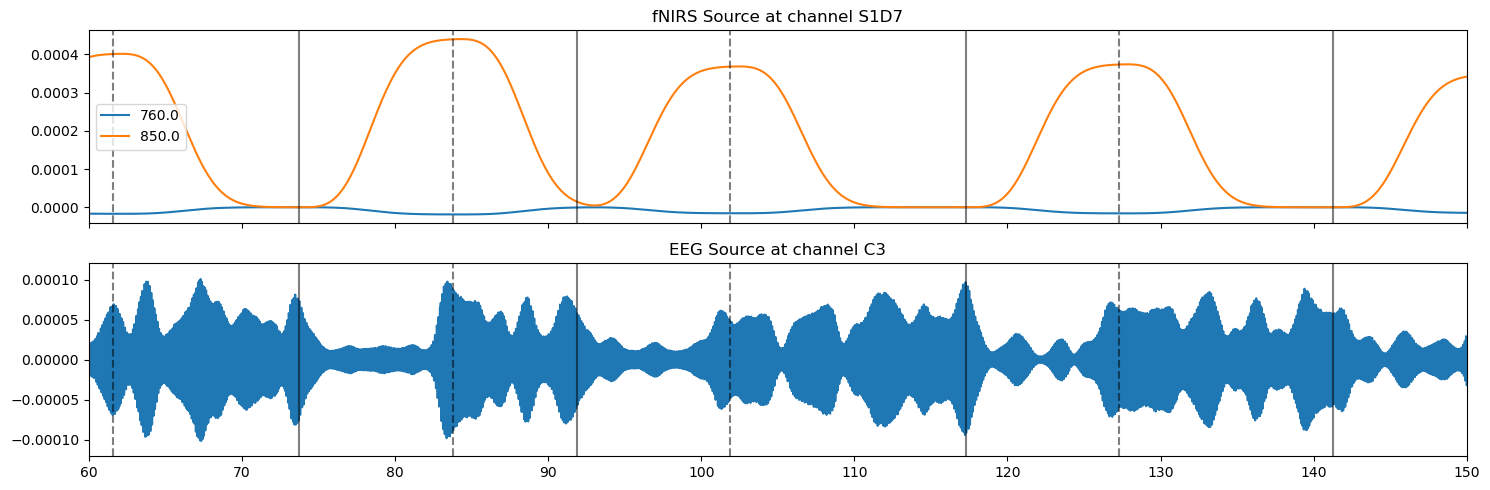

In [28]:
# Visualize final simulated data
ch_fnirs = 'S1D7'
ch_eeg = 'C3'
xlim = (60, 150)

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 5), sharex=True) 

ax1.plot(fnirs_sim.time, fnirs_sim.sel(wavelength=wl1, channel=ch_fnirs), label=wl1)
ax1.plot(fnirs_sim.time, fnirs_sim.sel(wavelength=wl2, channel=ch_fnirs), label=wl2)
for on, off in zip(stim.onset.values, stim.onset.values + stim.duration.values):
    ax1.axvline(on, color='k', ls='-', alpha=0.5)
    ax1.axvline(off, color='k', ls='--', alpha=0.5)
ax1.set_title(f'fNIRS Source at channel {ch_fnirs}')
ax1.set_xlim(*xlim)
ax1.legend()

ax2.plot(eeg_sim.time, eeg_sim.sel(channel=ch_eeg))
for on, off in zip(stim.onset.values, stim.onset.values + stim.duration.values):
    ax2.axvline(on, color='k', ls='-', alpha=0.5)
    ax2.axvline(off, color='k', ls='--', alpha=0.5)
ax2.set_xlim(*xlim)
ax2.set_title(f'EEG Source at channel {ch_eeg}')

plt.tight_layout()
plt.show()

### Add background to simulated data

We now use the background data as realistic noise on top of the simulated stimulus. For that, we first bring simulated and background datasets to compatible formats by restricting them to the same number of channels and sampling rate. Then, the synthetic activity is activity is added to the background data with a scaling parameter $\gamma$ that allows regulating the SNR. (Here we pick a very high value of $gamma$ just for visualization purposes!)

In [29]:
def add_background(fnirs_bg, eeg_bg, fnirs_sim, eeg_sim, gamma):

    # Read channels
    fnirs_bg_channels = fnirs_bg.channel.values
    eeg_bg_channels = eeg_bg.channel.values

    # Restrict simulated data to non-prunned channels
    fnirs_sim_compatible = fnirs_sim.sel(channel=fnirs_bg_channels)
    eeg_sim_compatible = eeg_sim.sel(channel=eeg_bg_channels)

    # Downsample simulated time series to the rate of the smallest one
    fnirs_sim_compatible = fnirs_sim_compatible.sel(time=fnirs_bg.time, method='nearest')
    fnirs_sim_compatible = fnirs_sim_compatible.assign_coords({'samples': ('time', fnirs_bg.samples.values)})
    eeg_sim_compatible = eeg_sim_compatible.sel(time=eeg_bg.time, method='nearest')
    eeg_sim_compatible = eeg_sim_compatible.assign_coords({'samples': ('time', eeg_bg.samples.values)})

    # Identify channel with maximum simulated activity
    ch_max_eeg = np.abs(eeg_sim_compatible).max(dim='time').argmax(dim='channel').data
    ch_max_fnirs = np.abs(fnirs_sim_compatible).max(dim=['time', 'wavelength']).argmax(dim='channel').data

    # Scale simulated data to match amplitude of background data
    eeg_sim_compatible *= np.linalg.norm(eeg_bg.data[ch_max_eeg])/np.linalg.norm(eeg_sim_compatible.data[ch_max_eeg])
    for i in range(2):
        fnirs_sim_compatible[i] *= np.linalg.norm(fnirs_bg.data[i, ch_max_fnirs])/np.linalg.norm(fnirs_sim_compatible.data[i, ch_max_fnirs])

    # Add gamma-scaled simulated data to background noise
    fnirs =fnirs_sim_compatible.copy()
    fnirs.data = gamma * fnirs_sim_compatible.data + fnirs_bg.data
    eeg = eeg_sim_compatible.copy()
    eeg.data = gamma * eeg_sim_compatible.data + eeg_bg.data

    return fnirs, eeg

In [30]:
# Add background data to simulated data (pick very high value just for visualization!)
fnirs, eeg = add_background(fnirs_bg_preprocessed, eeg_bg_preprocessed_xr, fnirs_sim, eeg_sim, gamma=5)

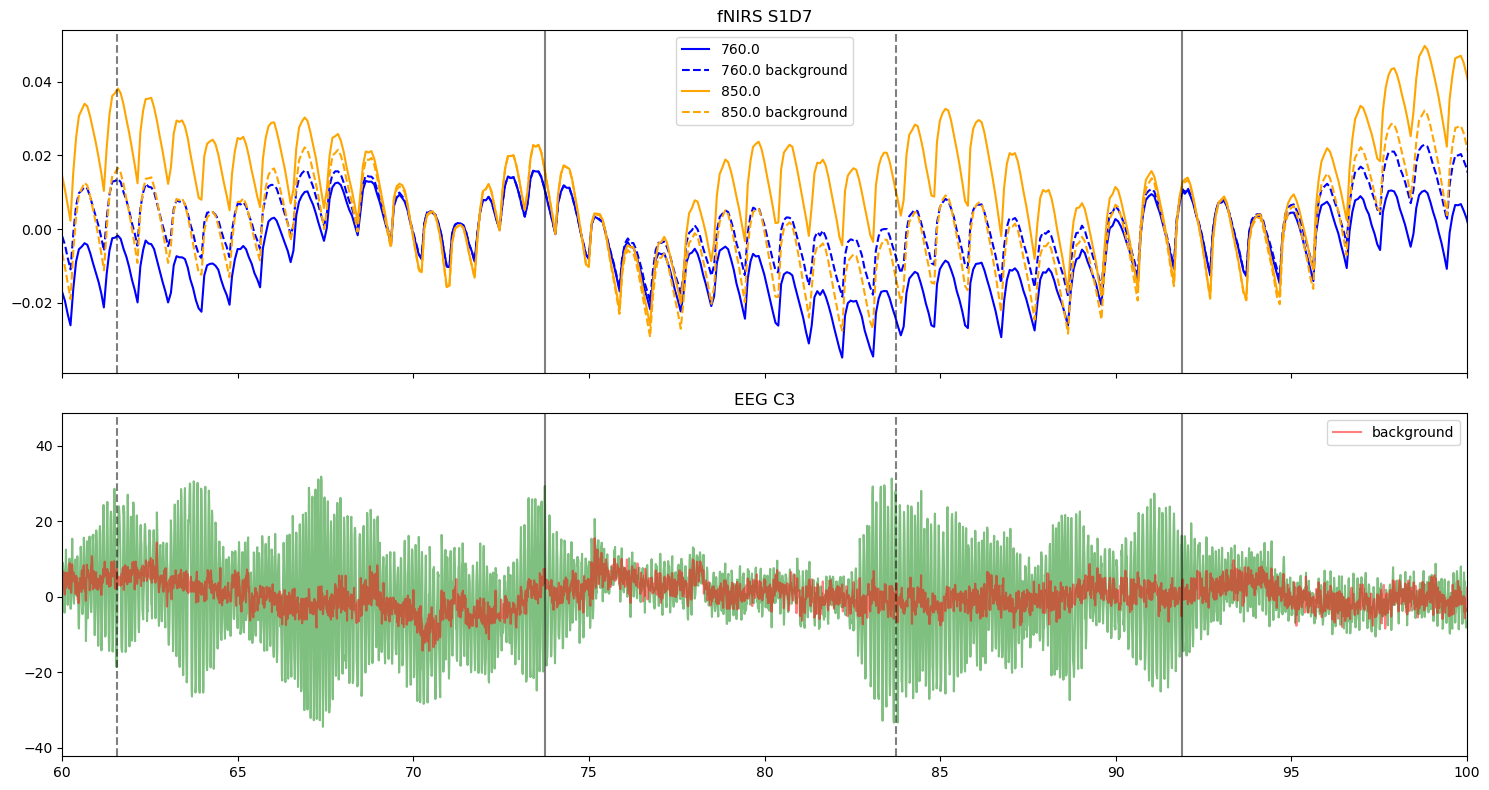

In [31]:
# Visualize final realistic simulated data
ch_fnirs = 'S1D7'
ch_eeg = 'C3'
xlim = (60, 100)

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True) 

ax1.plot(fnirs.time, fnirs.sel(wavelength=wl1, channel=ch_fnirs), 'b-', label=wl1)
ax1.plot(fnirs_bg_preprocessed.time, fnirs_bg_preprocessed.sel(wavelength=wl1, channel=ch_fnirs), 'b--', label=f'{wl1} background')
ax1.plot(fnirs.time, fnirs.sel(wavelength=wl2, channel=ch_fnirs), color='orange', ls='-', label=wl2)
ax1.plot(fnirs_bg_preprocessed.time, fnirs_bg_preprocessed.sel(wavelength=wl2, channel=ch_fnirs), color='orange', ls='--', label=f'{wl2} background')
for on, off in zip(stim.onset.values, stim.onset.values + stim.duration.values):
    ax1.axvline(on, color='k', ls='-', alpha=0.5)
    ax1.axvline(off, color='k', ls='--', alpha=0.5)
ax1.set_title(f'fNIRS {ch_fnirs}')
ax1.set_xlim(*xlim)
ax1.legend()

ax2.plot(eeg.time, eeg.sel(channel=ch_eeg), 'g-', alpha=0.5)
ax2.plot(eeg_bg_preprocessed_xr.time, eeg_bg_preprocessed_xr.sel(channel=ch_eeg), 'r-', alpha=0.5, label='background')
for on, off in zip(stim.onset.values, stim.onset.values + stim.duration.values):
    ax2.axvline(on, color='k', ls='-', alpha=0.5)
    ax2.axvline(off, color='k', ls='--', alpha=0.5)
ax2.set_xlim(*xlim)
ax2.set_title(f'EEG {ch_eeg}')
ax2.legend()

plt.tight_layout()
plt.show()

## Source decomposition methods

In this section we apply some source decomposition methods on the synthetic data and test and compare their performance.

### Data preprocessing

The synthetic data corresponds to the raw data as it would come directly from an experiment. We now apply a preprocessing pipeline to fNIRS and EEG data individually to bring it a curated format to which we can apply our source decomposition methods.

In [32]:
def downsample(x, new_time=None, new_rate=None):
    """Downsample signal x to match new rate.

    The subsampled signal is obtained by separating x in equal-size bins and 
    averaging within them. The new time is defined by the closest time point in x to
    the a new downsampled time, time_ds.
    """
    if new_rate:
        time_ds = np.arange(x.time[0].data, x.time[-1].data, 1/new_rate)  # Miss last point
        time_ds = np.append(time_ds, x.time[-1].data)  # Add last time point
        new_time = x.time[x.time.searchsorted(time_ds)] 

    N = len(new_time)
    x_ds = x.groupby_bins(group='time', bins=N).mean().rename({'time_bins': 'time'}).assign_coords({'time': new_time})

    return x_ds

#### fNIRS

fNIRS preprocessing involves channel pruning using the scalp coupling index and peak spectral power quality metrics (Pollonini et al., 2016), bandpass filtering from 0.01 Hz to 0.6 Hz to remove cardiac component and slow drifts, linear detrending, and 2 Hz dowsampling.

In [33]:
def preprocess_fnirs(fnirs, s_temporal_fnirs, rate_ds, T_sim, wl2=850., source_location_landmark='C3'):

    # fNIRS data and ground truth source
    y = fnirs.sel(wavelength=wl2).copy().transpose('time', 'channel')
    y = y.assign_coords({'time': y.time.assign_attrs({'units': cedalion.units.s})})
    sy = s_temporal_fnirs.copy().expand_dims({'source': [source_location_landmark]}).transpose('time', 'source')

    # Bandpass filter
    fmin = 0.01 * units.Hz
    fmax = 0.6 * units.Hz
    y = freq_filter(y, fmin, fmax)

    # Downsample
    time_ds = np.append(np.arange(0, T_sim, 1/rate_ds), T_sim)
    N_ds = len(time_ds)
    y = y.groupby_bins(group='time', bins=N_ds).mean().rename({'time_bins': 'time'}).assign_coords({'time': time_ds})
    sy = sy.groupby_bins(group='time', bins=N_ds).mean().rename({'time_bins': 'time'}).assign_coords({'time': time_ds})

    return y, sy

y, sy = preprocess_fnirs(fnirs, s_temporal_fnirs, rate_ds=4, T_sim=T_sim, wl2=wl2, source_location_landmark=source_location_landmark)

/var/folders/xm/0q8cx_5n0vx8g4y5yssnsrbc0000gn/T/ipykernel_65095/2612671950.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[i].legend()


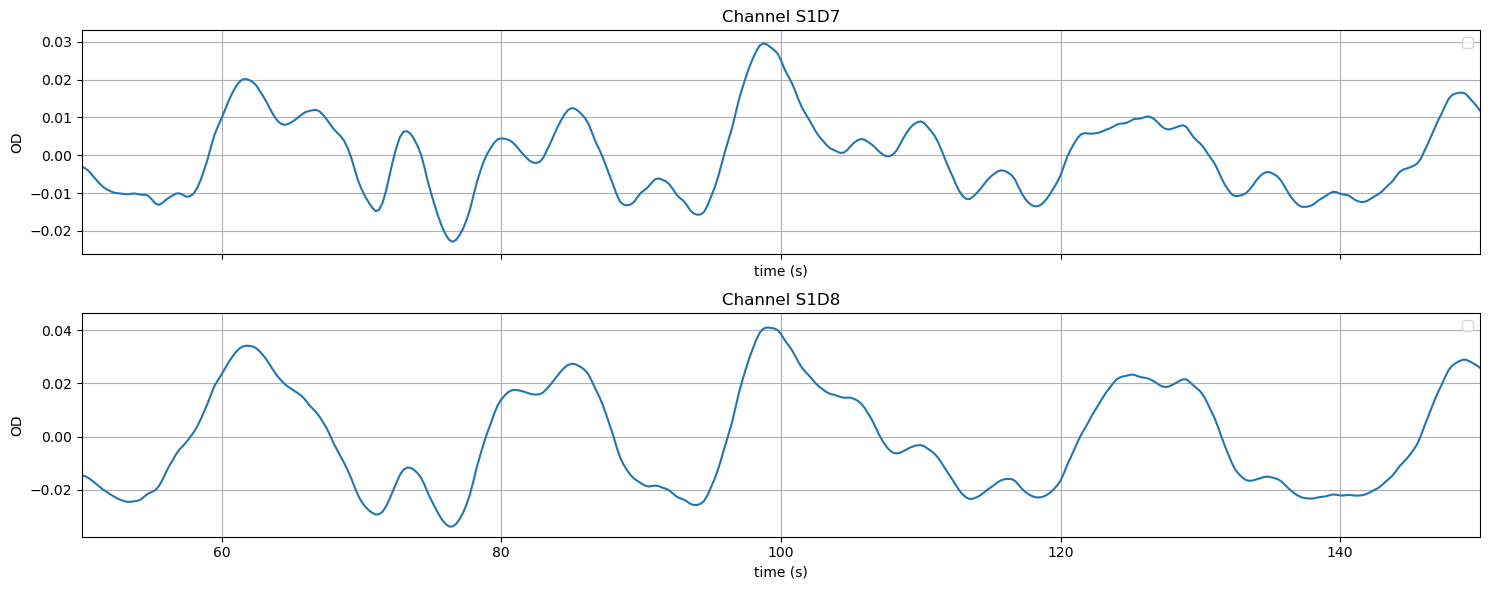

In [34]:
# Plot preprrocessed fNIRS data
fnirs_ch_to_plot = ['S1D7', 'S1D8'] # [c for c in fnirs_bg_preprocessed.channel.values if 'S1D' in c]
f, ax = plt.subplots(len(fnirs_ch_to_plot), 1, figsize=(15, 3*len(fnirs_ch_to_plot)), sharex=True)

for i, c in enumerate(fnirs_ch_to_plot):
    ax[i].plot(y.time, y.sel(channel=c))
    ax[i].set_title(f"Channel {c}")
    ax[i].legend()
    ax[i].set_xlabel("time (s)")
    ax[i].set_ylabel("OD")
    ax[i].grid()

plt.xlim(50, 150)
plt.tight_layout()
plt.show()

#### EEG

For EEG data we already performed substantial preprocessing before adding the synthetic stimuli. The remaining steps involve a linear EOG regression algorithm for ocular artifact removal, and bandpass filtering in the alpha band. In this step, we also estimate time course bandpower by splitting the data into equal-length segments and calculating the per-segment variance, resulting in an effective 2 Hz downsampling.

In [35]:
def EOG_removal(eeg, eog):
    """Apply a linear regression method via least squares to remove EOG contributions from EEG channels.
    """

    # Bring them to desired format
    eeg = eeg.transpose('channel', 'time')
    eog = eog.transpose('channel', 'time')

    # Define matrices of the linear model
    S_artifact = eog.data
    X = eeg.data

    # Estimate linear projection via least squares
    S_artifact_pinv = sp.linalg.pinv(S_artifact)  # Moore-Penrose pseudoinverse
    A_artifact = X @ S_artifact_pinv
    
    # Construct artifact contribution to EEG channels
    A_artifact_pinv = sp.linalg.pinv(A_artifact)
    X_artifact = (A_artifact @ A_artifact_pinv) @ X

    # Subtract from original EEG channels to get a clean version of them
    X_clean = X - X_artifact

    # Substitute clean data in xArray
    eeg_clean = eeg.copy()
    eeg_clean.data = X_clean

    # Bring back to original format
    eeg_clean = eeg_clean.transpose('time', 'channel')

    return eeg_clean


def preprocess_eeg(eeg, eog, s_temporal_eeg_amp, rate_ds, T_sim, source_location_landmark='C3'):
    """Preprocess EEG data.
    """

    # EEG data and ground truth source
    x = eeg.copy()
    x = x.assign_coords({'time': x.time.assign_attrs({'units': cedalion.units.s})}).transpose('time', 'channel')
    sx = s_temporal_eeg_amp.copy().expand_dims({'source': [source_location_landmark]}).transpose('time', 'source')

    # Apply a linear regression method via least squares to remove EOG contributions from EEG channels
    x = EOG_removal(x, eog)

    # Bandpass filter in the alpha band range
    x = freq_filter(x, fmin=8 * units.Hz, fmax=12 * units.Hz)

    # Divide original EEG data into epochs, matching new downsampled time, and estimate power as within-epoch variance.
    time_ds = np.append(np.arange(0, T_sim, 1/rate_ds), T_sim)
    N_ds = len(time_ds)
    x_power = x.groupby_bins(group='time', bins=N_ds).var().rename({'time_bins': 'time'}).assign_coords({'time': time_ds})

    # Downsample ground truth 
    sx = sx.groupby_bins(group='time', bins=N_ds).mean().rename({'time_bins': 'time'}).assign_coords({'time': time_ds})

    return x, x_power, sx

x, x_power, sx = preprocess_eeg(eeg, eog, s_temporal_eeg_amp, rate_ds=4, T_sim=T_sim, source_location_landmark=source_location_landmark)


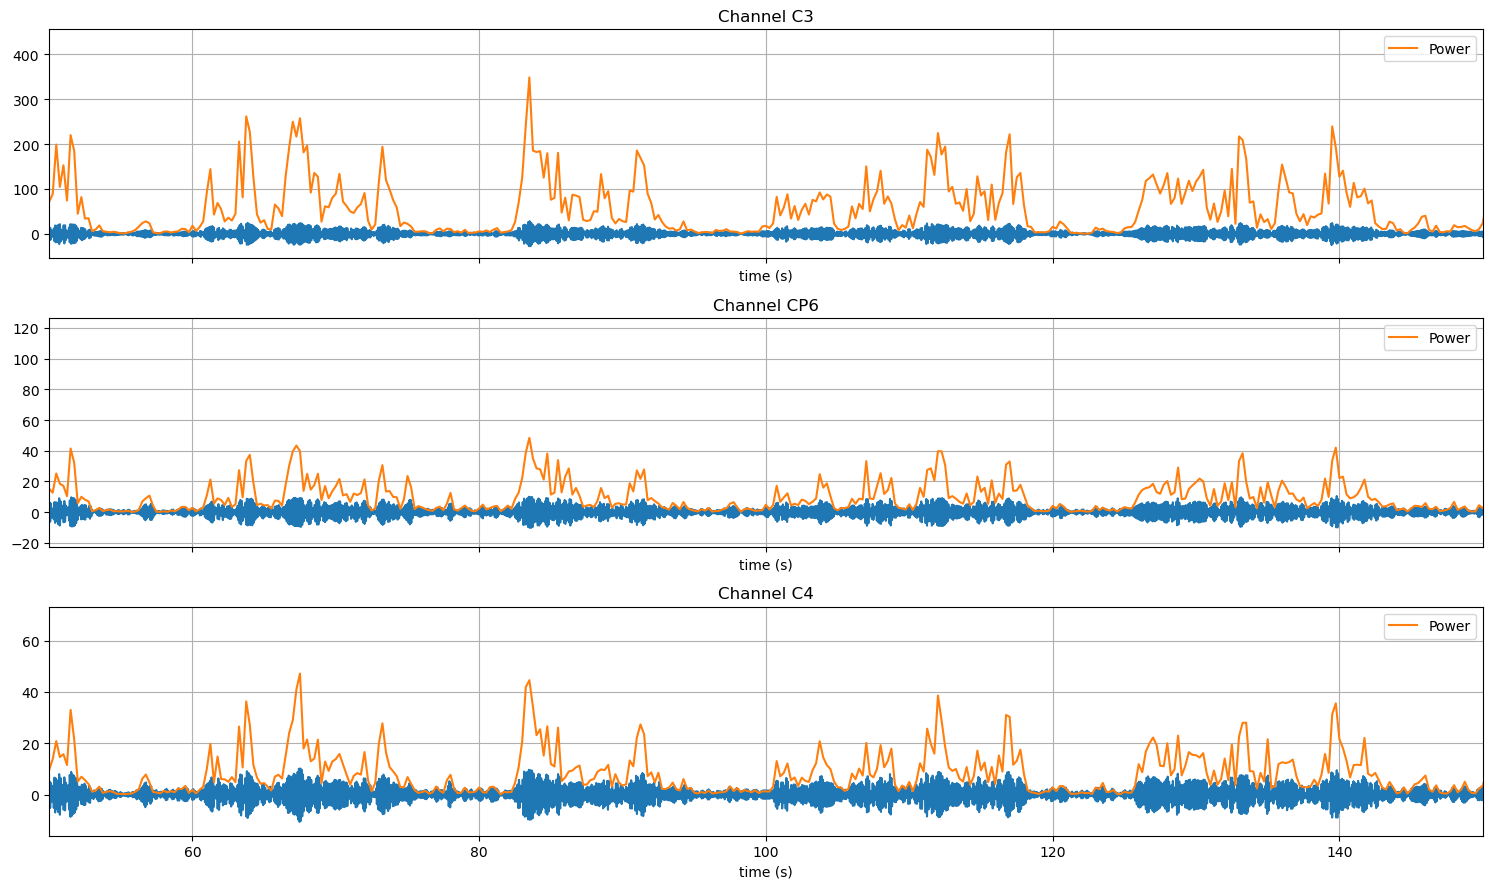

In [36]:
# Plot preprrocessed fNIRS data
eeg_ch_to_plot = ['C3', 'CP6', 'C4']
f, ax = plt.subplots(len(eeg_ch_to_plot), 1, figsize=(15, 3*len(eeg_ch_to_plot)), sharex=True)

for i, c in enumerate(eeg_ch_to_plot):
    ax[i].plot(x.time, x.sel(channel=c))
    ax[i].plot(x_power.time, x_power.sel(channel=c), label='Power')
    ax[i].set_title(f"Channel {c}")
    ax[i].legend()
    ax[i].set_xlabel("time (s)")
    ax[i].grid()
    # ax[i].set_ylim(-10, 20)

plt.xlim(50, 150)
plt.tight_layout()
plt.show()

### Split into trials and train/test sets

We divide the three datasets, namely fNIRS, EEG, and EEG bandpower time series, into individual trials, composed of the stimulus period (10s) plus pre and post-stimulus resting periods of constant length (4s) each. We then perform a random 80%/20% train/test set split, resulting in 10 and 2 trials, respectively. Trials in the train set are then concatenated along the time direction to generate a single time-course input dataset for each modality, while test trials are kept separated.

In [37]:
def standardize(x, dim='time', scale=True):
    """Standardize x along dimension dim. 
    """

    mean = x.mean(dim=dim)

    if scale:
        std = x.std(dim=dim)
        std[std==0] = 1  # Avoid division by 0
    else:
        std = xr.ones_like(mean)
    
    x_standard = (x - mean)/std
        
    return x_standard

def shuffle_datasets(*datasets, seed=None):
    """Shuffle multiple datasets using the same shuffled indices.
    
    Args:
        *datasets: Arrays or lists of the same length to be shuffled.
        seed: Optional random seed for reproducibility.
        
    Returns:
        A tuple of shuffled datasets.
    """
    if not datasets:
        raise ValueError("No datasets provided.")
    
    length = len(datasets[0])
    for dataset in datasets:
        if len(dataset) != length:
            raise ValueError("All datasets must have the same length.")
    
    np.random.seed(seed)
    indices = np.random.permutation(length)
    
    shuffled_datasets = [[dataset[i] for i in indices] for dataset in datasets]
    
    return shuffled_datasets

def train_test_split(datasets_dict, train_size=0.2, seed=None):
    """Split multiple datasets into training and testing sets using the same shuffle order.
    
    Args:
        datasets_dict: Dictionary containing equal-length datasets to be split.
        test_size: Proportion of the dataset to include in the test split (default 0.2).
        seed: Optional random seed for reproducibility.
        
    Returns:
        A dictionary containing the train/test splits for each dataset.
    """
    labels = datasets_dict.keys()
    datasets = list(datasets_dict.values())

    shuffled_datasets = shuffle_datasets(*datasets, seed=seed)
    split_idx = int(len(datasets[0]) * train_size)
    
    train_dict = {}
    test_dict = {}
    for label, dataset in zip(labels, shuffled_datasets):
        train_dict[f"{label}"] = dataset[:split_idx]
        test_dict[f"{label}"] = dataset[split_idx:]
    
    return train_dict, test_dict


def aggregate_trials(trials_dict, time_trial):
    """Combine trials by concatenating them along the time dimension.
    """
    
    T_trial = time_trial[-1]
    N_trials = len(list(trials_dict.values())[0])
    time_train = np.concatenate([time_trial + i * T_trial for i in range(N_trials)])
    
    trials_aggregated_dict = {}
    for k, trials in trials_dict.items():
        trials_aggregated = xr.concat(trials, dim='time').assign_coords({'time': time_train})
        trials_aggregated_dict[k] = trials_aggregated
    
    return trials_aggregated_dict, time_train

In [38]:
def split_into_trials(t_rest, stim, x, x_power, y, sx, sy):
    """Split datasets into trials
    """

    # Prepare times to split into trials
    ti_trials = stim.onset.values - t_rest
    tf_trials = stim.onset.values + stim.duration.values  + t_rest

    # Since trial sizes may differ due to rounding errors, we truncate them using this minimum value
    time_ds = y.time
    ti_ndx_y, tf_ndx_y = time_ds.searchsorted(ti_trials), time_ds.searchsorted(tf_trials)
    trial_size_y = (tf_ndx_y - ti_ndx_y).min()
    # Split donsampled timeseries into trials
    time_trials = [time_ds[i:f][:trial_size_y] for i, f in zip(ti_ndx_y, tf_ndx_y)]
    x_power_trials = [standardize(x_power[i:f][:trial_size_y], dim='time') for i, f in zip(ti_ndx_y, tf_ndx_y)]
    y_trials = [standardize(y[i:f][:trial_size_y], dim='time') for i, f in zip(ti_ndx_y, tf_ndx_y)]
    sx_trials = [standardize(sx[i:f][:trial_size_y], dim='time') for i, f in zip(ti_ndx_y, tf_ndx_y)]
    sy_trials = [standardize(sy[i:f][:trial_size_y], dim='time') for i, f in zip(ti_ndx_y, tf_ndx_y)]

    # Split x into trials and truncate their time to coincide with x_power_trials time.
    time_x = x.time
    ti_x = [t.time[0].data for t in x_power_trials]
    tf_x = [t.time[-1].data for t in x_power_trials]
    ti_ndx_x, tf_ndx_x = time_x.searchsorted(ti_x), time_x.searchsorted(tf_x)
    trial_size_x = (tf_ndx_x - ti_ndx_x).min()

    time_trials_x = [time_x.sel(time=slice(i, f))[:trial_size_x] for i, f in zip(ti_x, tf_x)]
    x_trials = [standardize(x.sel(time=slice(i, f))[:trial_size_x], dim='time') for i, f in zip(ti_x, tf_x)]

    # Align initial and final times of trials to the ones of x_power_trials
    for xt, xpt in zip(x_trials, x_power_trials):
        xt.time.data[0] = xpt.time.data[0]
        xt.time.data[-1] = xpt.time.data[-1]

    # Pick a representative time trial
    time_trial = time_trials[0]
    time_trial = time_trial - time_trial[0] # Remove onsets

    # And a representative trial for x, which is not downsampled
    time_trial_x = time_trials_x[0]
    time_trial_x = time_trial_x - time_trial_x[0] # Remove onsets

    # Split datasets into training and testing sets using the same shuffle order
    trials_dict = {'x': x_trials, 
                    'x_power': x_power_trials,
                    'y': y_trials, 
                    'sx': sx_trials, 
                    'sy': sy_trials}
    
    return trials_dict, time_trial, time_trial_x

In [39]:
# Split datasets into trials
trials_dict, time_trial, time_trial_x = split_into_trials(T_rest_min // 2, stim, x, x_power, y, sx, sy)

# Train/test split
train_size = 0.8
train_dict, test_dict = train_test_split(trials_dict, train_size)
# Separate the only dataset that has a different sampling rate (x)
x_train_dict = {'x': train_dict.pop('x')}

# Aggregate trials: concatenate all train trials into a continuous train set
train_aggregated_dict, time_train = aggregate_trials(train_dict, time_trial)
x_train_aggregated_dict, time_train_x = aggregate_trials(x_train_dict, time_trial_x)

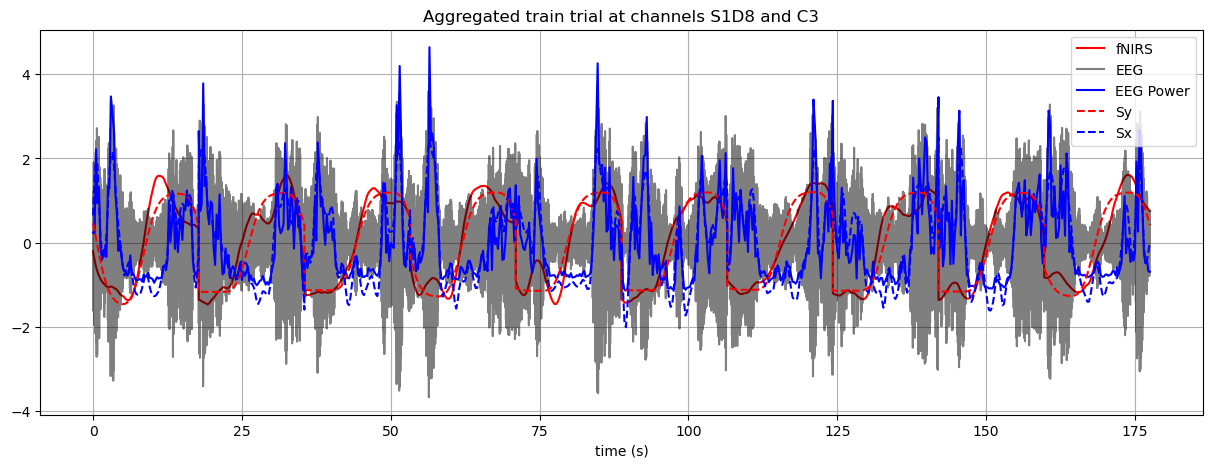

In [40]:
# Visualize aggregated train data
fnirs_ch = 'S1D8'
eeg_ch = 'C3'
ndx = 0

x_power_train = train_aggregated_dict['x_power'].sel(channel=eeg_ch)
x_train = x_train_aggregated_dict['x'].sel(channel=eeg_ch)
y_train = train_aggregated_dict['y'].sel(channel=fnirs_ch)
sx_train = train_aggregated_dict['sx']
sy_train = train_aggregated_dict['sy']


plt.figure(figsize=(15, 5))

plt.plot(y_train.time, y_train, 'r-', label='fNIRS')
plt.plot(x_train.time, x_train, 'k-', label='EEG', alpha=0.5)
plt.plot(x_power_train.time, x_power_train, 'b-', label='EEG Power')
plt.plot(sy_train.time, sy_train, 'r--', label='Sy')
plt.plot(sx_train.time, sx_train, 'b--', label='Sx')
plt.title(f"Aggregated train trial at channels {fnirs_ch} and {eeg_ch}")
plt.legend()
plt.xlabel("time (s)")
plt.grid()
plt.show()

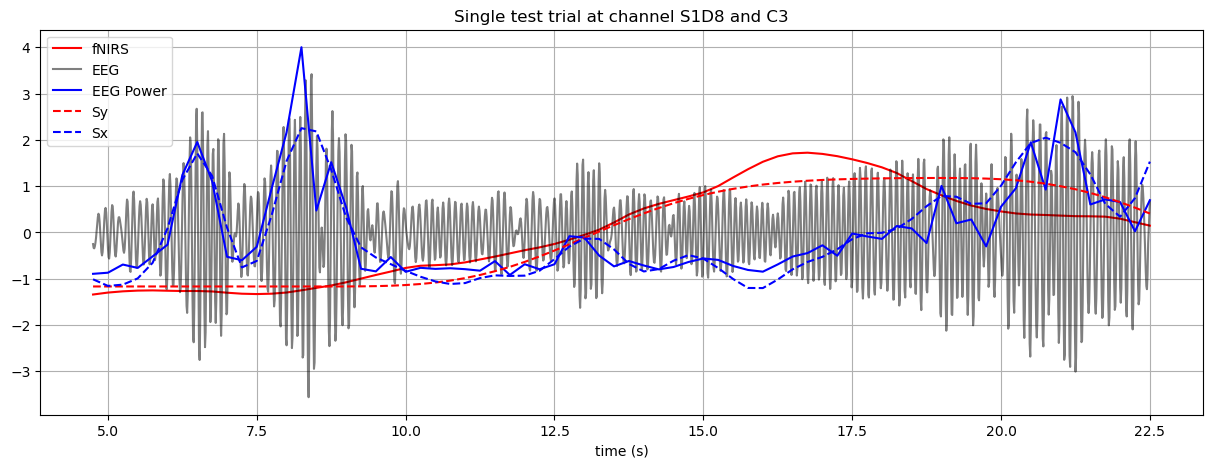

In [41]:
# Visualize a single test trial
fnirs_ch = 'S1D8'
eeg_ch = 'C3'
ndx = 0

x_power_test = test_dict['x_power'][ndx].sel(channel=eeg_ch)
x_test = test_dict['x'][ndx].sel(channel=eeg_ch)
y_test = test_dict['y'][ndx].sel(channel=fnirs_ch)
sx_test = test_dict['sx'][ndx]
sy_test = test_dict['sy'][ndx]

plt.figure(figsize=(15, 5))

plt.plot(y_test.time, y_test, 'r-', label='fNIRS')
plt.plot(x_test.time, x_test, 'k-', label='EEG', alpha=0.5)
plt.plot(x_power_test.time, x_power_test, 'b-', label='EEG Power')
plt.plot(sy_test.time, sy_test, 'r--', label='Sy')
plt.plot(sx_test.time, sx_test, 'b--', label='Sx')
plt.title(f"Single test trial at channel {fnirs_ch} and {eeg_ch}")
plt.legend()
plt.xlabel("time (s)")
plt.grid()
plt.show()

### Test methods performance 

We now run 50 simulations with 12 trials each. Each simulation produce different temporal profiles for the EEG and fNIRS true sources due to the randomness in stimulus amplitudes and recovery times, but the source spatial profiles and the background data are always
the same. For each simulation, we combine synthetic and background data using 20 different SNR values, from -25 dB to 10 dB.

#### Helper functions

Before running the simulations, we build some helper functions to run the full simulation.

In [ ]:
def compute_trial_correlations(x, y, sx_gt, sy_gt, model):
    """
    Transform x and y and using model and compare the resulting sources with the groun truth sources.
    """
    
    # Compute sources
    sx, sy = model.transform(x, y)
    sx, sy = standardize(sx).T, standardize(sy).T
    # Fix mismatch dimensions due to time shift and truncated padding
    Ntx = len(sx.time)
    Nty = len(sy.time)
    
    if Ntx < len(sx_gt.time):
        sx_gt = sx_gt[:, :Ntx]
    if Nty < len(sy_gt.time):
        sy_gt = sy_gt[:, :Nty]

    # Compute cross correlations
    corrx = np.corrcoef(sx_gt[0], sx[0])[0, 1]
    corry = np.corrcoef(sy_gt[0], sy[0])[0, 1]
    
    return corrx, corry

def compute_spatial_pattern_correlations(x, y, Ax, Ay, wx, wy):
    """Compute correlations between estimated and true spatial patterns.
    """

    # Make sure channels are aligned
    x = x.sel(channel=wx.channel)
    y = y.sel(channel=wy.channel)
    Ax = Ax.sel(channel=wx.channel).data  # Also truncate when necessary
    Ay = Ay.sel(channel=wy.channel).data

    Ax_model = compute_spatial_pattern_from_weight(x, wx).T
    Ay_model = compute_spatial_pattern_from_weight(y, wy).T

    # Compute correlations
    corrx = np.abs(np.corrcoef(Ax_model[0], Ax)[0, 1])
    corry = np.abs(np.corrcoef(Ay_model[0], Ay)[0, 1])

    return corrx, corry

def compute_spatial_pattern_from_weight(X, W, sample_name='time', feature_name='channel'):
    """
    """
    
    # Bring to standard order
    X = X.transpose(sample_name, feature_name)
    W = W.transpose(feature_name, ...)
    
    # Work with numpy arrays from now on
    N = len(X[sample_name])
    X = X.data
    W = W.data
    # Covariance matrix for X
    C = (X.T @ X) / (N - 1)
    # Covariance matrix for reconstructed sources
    Cs = W.T @ C @ W
    # Estimated spattial pattern
    A = C @ W @ sp.linalg.pinv(Cs)
    
    return A

def fisher_z_stats(r_values):
    """Compute the Fisher z-transformation statistics for Pearson correlation coefficients.

    Args:
        r_values : list
            List of Pearson correlation coefficients.

    Returns:
        r_mean : float
            The back-transformed mean correlation.
        r_std : float
            The back-transformed standard deviation of the correlation.
    """ 

    # Convert list to numpy array
    r = np.array(r_values)

    # Fisher z-transformation
    z = np.arctanh(r)
    
    # Compute Mean and standard deviation in z-space omitting nan values
    z_mean = np.nanmean(z, axis=0)
    z_std = np.nanstd(z, axis=0, ddof=1)
    
    # Back-transform mean
    r_mean = np.tanh(z_mean)
    
    # Approximate symmetric bounds via delta-method
    r_std = (1 - r_mean**2) * z_std
    
    return r_mean, r_std

def run_simulation(fnirs_bg, eeg_bg, eog, A_fnirs_2wl, A_eeg, gamma_list, models, labels, simulation_parameters, N_components, time_shifts):
    
    # Read parameters from simulation_parameters
    source_location_landmark = simulation_parameters['source_location_landmark']
    T_sim = simulation_parameters['T_sim']
    T_stim = simulation_parameters['T_stim']
    T_rest_min = simulation_parameters['T_rest_min']
    T_rest_max = simulation_parameters['T_rest_max']
    stim_amp_min = simulation_parameters['stim_amp_min']
    stim_amp_max = simulation_parameters['stim_amp_max']
    simulation_rate = simulation_parameters['simulation_rate']
    N_sim = simulation_parameters['N_sim']
    train_size = simulation_parameters['train_size']
    rate_ds = simulation_parameters['rate_ds']
    var_explained = simulation_parameters['pca_var_explained']
    
    wl2 = fnirs_bg.wavelength.values[1]

    # Initialize lists of correlations between real and reconstructed sources
    corr_dict = {l: np.zeros([N_sim, len(gamma_list), 8]) for l in labels}
    mSPoC_Wts = np.zeros([N_sim, len(gamma_list), N_components, len(time_shifts)]) # Store temporal filters for mSPoC

    for i in range(N_sim):

        print(f"Simulation {i+1}")
        
        # Simulate experiment markers
        stim, time_sim = simulate_experiment_markers(T_stim, T_rest_min, T_rest_max, stim_amp_min, stim_amp_max, source_location_landmark)
        # Simulate temporal profiles
        s_temporal_fnirs = build_fnirs_temporal_profile(stim, time_sim, fnirs_bg_preprocessed)
        s_temporal_eeg, s_temporal_eeg_amp = build_eeg_temporal_profile(stim, time_sim, simulation_rate)       
        # Apply forward models
        fnirs_sim = A_fnirs_2wl * s_temporal_fnirs
        eeg_sim =  A_eeg * s_temporal_eeg
        # Restrict to one wavelength for later 
        A_fnirs = A_fnirs_2wl.sel(wavelength=850)
        
        for j, gamma in enumerate(gamma_list):
            
            # Add background to simulated data using gamma
            fnirs, eeg = add_background(fnirs_bg, eeg_bg, fnirs_sim, eeg_sim, gamma=gamma)

            # Preprocess datasets
            y, sy = preprocess_fnirs(fnirs, s_temporal_fnirs, rate_ds, T_sim, wl2=wl2, source_location_landmark=source_location_landmark)
            x, x_power, sx = preprocess_eeg(eeg, eog, s_temporal_eeg_amp, rate_ds, T_sim, source_location_landmark=source_location_landmark)

            # Split datasets into trials
            trials_dict, time_trial, time_trial_x = split_into_trials(T_rest_min // 2, stim, x, x_power, y, sx, sy)

            # Train/test split
            train_dict, test_dict = train_test_split(trials_dict, train_size)
            # Separate the only dataset that has a different sampling rate (x)
            x_train_dict = {'x': train_dict.pop('x')}

            # Aggregate trials: concatenate all train trials into a continuous train set
            train_aggregated_dict, time_train = aggregate_trials(train_dict, time_trial)
            x_train_aggregated_dict, time_train_x = aggregate_trials(x_train_dict, time_trial_x)

            # Separate datasets
            sx_train = train_dict['sx']
            sy_train = train_dict['sy']
            sx_test = test_dict['sx']
            sy_test = test_dict['sy']
            

            for model, label in zip(models, labels):
                if 'mSPoC' not in label:
                    x_train_full = train_aggregated_dict['x_power']
                    x_train = train_dict['x_power']
                    x_test = test_dict['x_power']

                    y_train_full = train_aggregated_dict['y']
                    y_train = train_dict['y']
                    y_test = test_dict['y']

                    
                else:
                    x_train_full = x_train_aggregated_dict['x']
                    x_train = x_train_dict['x']
                    x_test = test_dict['x']

                    # Run PCA
                    # X modality
                    pcax = PCA(N_components=var_explained)
                    pcax.fit(x_train_full)
                    x_train_full = pcax.transform(x_train_full)
                    x_train = [pcax.transform(d) for d in x_train]
                    x_test = [pcax.transform(d) for d in x_test]
                    # Y modality
                    pcay = PCA(N_components=var_explained)
                    pcay.fit(y_train_full)
                    y_train_full = pcay.transform(y_train_full)
                    y_train = [pcay.transform(d) for d in y_train]
                    y_test = [pcay.transform(d) for d in y_test]
                
                # Fit
                model.fit(x_train_full, y_train_full)
                
                # Read filters
                if model.Wx.ndim == 3:
                    Wx = model.Wx.sel(time_shift=model.optimal_shift)[0]
                    Wy = model.Wy
                elif 'mSPoC' in label:
                    Wx = pcax.inverse_transform(model.Wx.T)
                    Wy = pcay.inverse_transform(model.Wy.T)
                    mSPoC_Wts[i, j, :, :] = model.Wt.T
                else:
                    Wx = model.Wx
                    Wy = model.Wy
                
                # Transform training data and average over them
                n_train = len(sx_train)
                corrx_train_avg = []
                corry_train_avg = []
                Acorrx_train_avg = []
                Acorry_train_avg = []

                for k in range(n_train):
                    corrx_train, corry_train = compute_trial_correlations(x_train[k], 
                                                                        y_train[k],
                                                                        sx_train[k].T, 
                                                                        sy_train[k].T, 
                                                                        model)
                    # Compute correlation between estimated and true spatial patterns
                    if 'mSPoC' in label:
                        x_train_mspoc = pcax.inverse_transform(x_train[k]).T
                        y_train_mspoc = pcay.inverse_transform(y_train[k]).T
                        Acorrx_train, Acorry_train = compute_spatial_pattern_correlations(x_train_mspoc,
                                                                                        y_train_mspoc,
                                                                                        A_eeg,
                                                                                        A_fnirs,
                                                                                        Wx,
                                                                                        Wy)
                    else:
                        Acorrx_train, Acorry_train = compute_spatial_pattern_correlations(x_train_dict['x'][k],
                                                                                    y_train[k],
                                                                                    A_eeg,
                                                                                    A_fnirs,
                                                                                    Wx,
                                                                                    Wy)
                    # Append correlations
                    corrx_train_avg.append(np.abs(corrx_train))
                    corry_train_avg.append(np.abs(corry_train))
                    Acorrx_train_avg.append(np.abs(Acorrx_train))
                    Acorry_train_avg.append(np.abs(Acorry_train))
                
                # Calculate a bias-corrected average for the Pearson correlation coefficients
                corrx_train_avg, _ = fisher_z_stats(corrx_train_avg)
                corry_train_avg, _ = fisher_z_stats(corry_train_avg)
                Acorrx_train_avg, _ = fisher_z_stats(Acorrx_train_avg)
                Acorry_train_avg, _ = fisher_z_stats(Acorry_train_avg)

                # Transform test data and average over them
                n_test = len(sx_test)
                corrx_test_avg = []
                corry_test_avg = []
                Acorrx_test_avg = []
                Acorry_test_avg = []

                for k in range(n_test):
                    corrx_test, corry_test = compute_trial_correlations(x_test[k], 
                                                                        y_test[k], 
                                                                        sx_test[k].T, 
                                                                        sy_test[k].T, 
                                                                        model)
                    # Compute correlation between estimated and true spatial patterns
                    if 'mSPoC' in label:
                        x_test_mspoc = pcax.inverse_transform(x_test[k]).T
                        y_test_mspoc = pcay.inverse_transform(y_test[k]).T
                        Acorrx_test, Acorry_test = compute_spatial_pattern_correlations(x_test_mspoc,
                                                                                        y_test_mspoc,
                                                                                        A_eeg,
                                                                                        A_fnirs,
                                                                                        Wx,
                                                                                        Wy)
                    else:
                        Acorrx_test, Acorry_test = compute_spatial_pattern_correlations(test_dict['x'][k],
                                                                                        y_test[k],
                                                                                        A_eeg,
                                                                                        A_fnirs,
                                                                                        Wx,
                                                                                        Wy)
                    # Append correlations
                    corrx_test_avg.append(np.abs(corrx_test))
                    corry_test_avg.append(np.abs(corry_test))
                    Acorrx_test_avg.append(np.abs(Acorrx_test))
                    Acorry_test_avg.append(np.abs(Acorry_test))

                # Calculate a bias-corrected average for the Pearson correlation coefficients
                corrx_test_avg, _ = fisher_z_stats(corrx_test_avg)
                corry_test_avg, _ = fisher_z_stats(corry_test_avg)
                Acorrx_test_avg, _ = fisher_z_stats(Acorrx_test_avg)
                Acorry_test_avg, _ = fisher_z_stats(Acorry_test_avg)

                corr_dict[label][i, j] = [corrx_train_avg, 
                                        corry_train_avg, 
                                        Acorrx_train_avg, 
                                        Acorry_train_avg,
                                        corrx_test_avg, 
                                        corry_test_avg,
                                        Acorrx_test_avg, 
                                        Acorry_test_avg,]
                
    return corr_dict, mSPoC_Wts

#### Run full simulation

We finally run the full simulation to compare some source decomposition methods: the mSPoC algorithm and temporally embedded versions of CCA, sCCA, Ridge CCA, ElasticNet CCA, and ssCCA. The regularization parameters for sCCA and Ridge CCA are
chosen to be $\lambda_{x1} = \lambda_{y1} = 0.2$, and $\lambda_{x2} = \lambda_{y2} = 0.8$ respectively, and their combination for ElasticNet CCA. ssCCA uses the same regularization parameters, while the EEG and fNIRS Laplacian matrices
are built using a binary nearest neighbors approach in which the adjacency matrices contain unit values where features (channels) are closer than the (pre-defined) distances of 25mm for fNIRS and 60mm for EEG. For the temporally embedded mehtods, time lags range from 1s to 4s in 1s steps. For mSPoC, we include an L2 penalty term to $w_x (\lambda_{x2} = 0.8)$ together with PCA-based dimensional reduction, keeping only 0.99 of the explained variance.

In [43]:
class PCA():
    
    def __init__(self, 
                 N_components=None):
        
        self.N_components = N_components
        self.pca = PCA_sk(n_components=N_components)
        
    def fit(self, X, sample_name='time', feature_name='channel'):
        
        self.sample_name = sample_name
        self.feature_name = feature_name
        self.feature = X[feature_name]

        X = X.transpose(sample_name, feature_name)
        
        self.pca.fit(X.data)
    
    def transform(self, X):
        
        X = X.transpose(self.sample_name, self.feature_name)
        
        X_new = self.pca.transform(X.data) 

        X_new = xr.DataArray(data=X_new, 
                             coords = {self.sample_name: X[self.sample_name],
                                       self.feature_name: [f'S{i}' for i in range(X_new.shape[1])]})

        return X_new
    def inverse_transform(self, X):

        extra_dim = X.dims[0]
        extra_coord = X[extra_dim]

        X_new = self.pca.inverse_transform(X.data).T
        
        X_new = xr.DataArray(data=X_new,
                             coords = {self.feature_name: self.feature,
                                       extra_dim: extra_coord})

        return X_new

def get_fnirs_channel_pos(channels, montage):
    
    ch_pos_dict = {}
    for ch in channels:
        source, detector = ch.split('D')
        detector = 'D' + detector
        source_pos = montage.sel(label=source).data.magnitude
        detector_pos = montage.sel(label=detector).data.magnitude
        ch_pos = (source_pos + detector_pos)/2
        ch_pos_dict[ch] = ch_pos
        
    return ch_pos_dict

def get_eeg_channel_pos(channels, montage):
    
    ch_pos_dict = {ch: montage.sel(label=ch).data.magnitude for ch in channels}
        
    return ch_pos_dict

def build_laplace(nodes, eps):
    """
    Builds Laplacian matrix of a graph, whose nodes are the components of the 1D vector nodes, 
    by giving unit weight to connected nodes only if they are close enough. The latter condition
    is determined by comparing the 2-norm between nodes and eps.
    """
    
    N = len(nodes)
    W = np.zeros([N, N])  # Adjacency matrix
    D = np.eye(N)  # Degree matrix
    
    for i, xi in enumerate(nodes):
        for j, xj in enumerate(nodes):
            are_close = np.linalg.norm(xi - xj) < eps
            W[i, j] = 1 if are_close else 0
        D[i, i] = np.sum(W[i])
    
    L = D - W  # Laplace matrix
    
    return W, D, L

In [44]:
# Load background data and mixing matrices to avoid recomputing them
fnirs_bg = xr.load_dataarray(os.path.join(TMP_DIR, 'fnirs_bg_preprocessed.nc'))
eeg_bg = xr.load_dataarray(os.path.join(TMP_DIR, 'eeg_bg_preprocessed.nc'))
eog = xr.load_dataarray(os.path.join(TMP_DIR, 'eog.nc'))
A_fnirs = xr.load_dataarray(os.path.join(TMP_DIR, 'A_fnirs.nc'))
A_eeg = xr.load_dataarray(os.path.join(TMP_DIR, 'A_eeg.nc'))

In [45]:
simulation_parameters = {
    'source_location_landmark': 'C3',
    'T_sim': T_sim,
    'T_stim': 10,
    'T_rest_min': 8,
    'T_rest_max': 16,
    'stim_amp_min': 0.5,
    'stim_amp_max': 0.8,
    'simulation_rate': eeg_bg_rate,
    'N_sim': 5, # 50,
    'train_size': 0.8,
    'rate_ds': 2,
    'pca_var_explained': .99
}

# SNR list and corresponding gammas
snr_list = np.linspace(-25, 10, 20)
gamma_list = 10**(snr_list/20)

# Temporal embedding parameters
dt = 1
N_lags = 5
time_shifts = np.arange(0, dt*N_lags, dt)
dt = 1

# Build Laplace matrices for ssCCA
Lx_eps = 60
Ly_eps = 25
ch_fnirs_pos = get_fnirs_channel_pos(fnirs_bg.channel.data.tolist(), montage)
ch_eeg_pos = get_eeg_channel_pos(eeg_bg.channel.data.tolist(), montage)
W_fnirs, D_fnirs, L_fnirs = build_laplace(ch_fnirs_pos.values(), eps=Ly_eps)
W_eeg, D_eeg, L_eeg = build_laplace(ch_eeg_pos.values(), eps=Lx_eps)

# Models
N_components = 1 
cca = CCA(N_components=1)
tcca = ElasticNetTCCA(N_components, l1_reg=0, l2_reg=0.0, 
                      time_shifts=time_shifts, shift_source=True)
stcca = ElasticNetTCCA(N_components, l1_reg=0.1, l2_reg=0.0, 
                       time_shifts=time_shifts, shift_source=True)
rtcca = ElasticNetTCCA(N_components, l1_reg=0, l2_reg=0.8, 
                       time_shifts=time_shifts, shift_source=True)
elastictcca = ElasticNetTCCA(N_components, l1_reg=0.1, l2_reg=0.8, 
                             time_shifts=time_shifts, shift_source=True)
mspoc = mSPoC(N_components, N_restarts=4, max_iter=200, tol=1e-4, 
              time_shifts=time_shifts, shift_source=True)
sstcca = StructuredSparseTCCA(N_components, Lx=L_eeg, Ly=L_fnirs, l1_reg=0.1, l2_reg=0.8, 
                              time_shifts=time_shifts, shift_source=True, pls=False)


models = [cca, tcca, stcca, rtcca, elastictcca, sstcca, mspoc]
labels = ['CCA', 'tCCA', 'stCCA', 'RidgetCCA', 'ElastictCCA', 'sstCCA', 'mSPoC']

corr_dict, mSPoC_Wts = run_simulation(fnirs_bg, eeg_bg, eog, A_fnirs, A_eeg, gamma_list, models, labels, simulation_parameters, N_components, time_shifts)

Simulation 1


/opt/anaconda3/envs/cedalion/lib/python3.11/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


Simulation 2
mSPoC did not converged in any of the 4 restarts! (Reached maximum number of iterations). Returning last computed filters and correlation.
mSPoC did not converged in any of the 4 restarts! (Reached maximum number of iterations). Returning last computed filters and correlation.
Simulation 3
mSPoC did not converged in any of the 4 restarts! (Reached maximum number of iterations). Returning last computed filters and correlation.
mSPoC did not converged in any of the 4 restarts! (Reached maximum number of iterations). Returning last computed filters and correlation.
Simulation 4
mSPoC did not converged in any of the 4 restarts! (Reached maximum number of iterations). Returning last computed filters and correlation.
mSPoC did not converged in any of the 4 restarts! (Reached maximum number of iterations). Returning last computed filters and correlation.
mSPoC did not converged in any of the 4 restarts! (Reached maximum number of iterations). Returning last computed filters and c

/var/folders/xm/0q8cx_5n0vx8g4y5yssnsrbc0000gn/T/ipykernel_65095/2796724573.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1, 0].set_xticklabels(np.arange(-30, 15, 5), fontsize=15)
/var/folders/xm/0q8cx_5n0vx8g4y5yssnsrbc0000gn/T/ipykernel_65095/2796724573.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1, 1].set_xticklabels(np.arange(-30, 15, 5), fontsize=15)


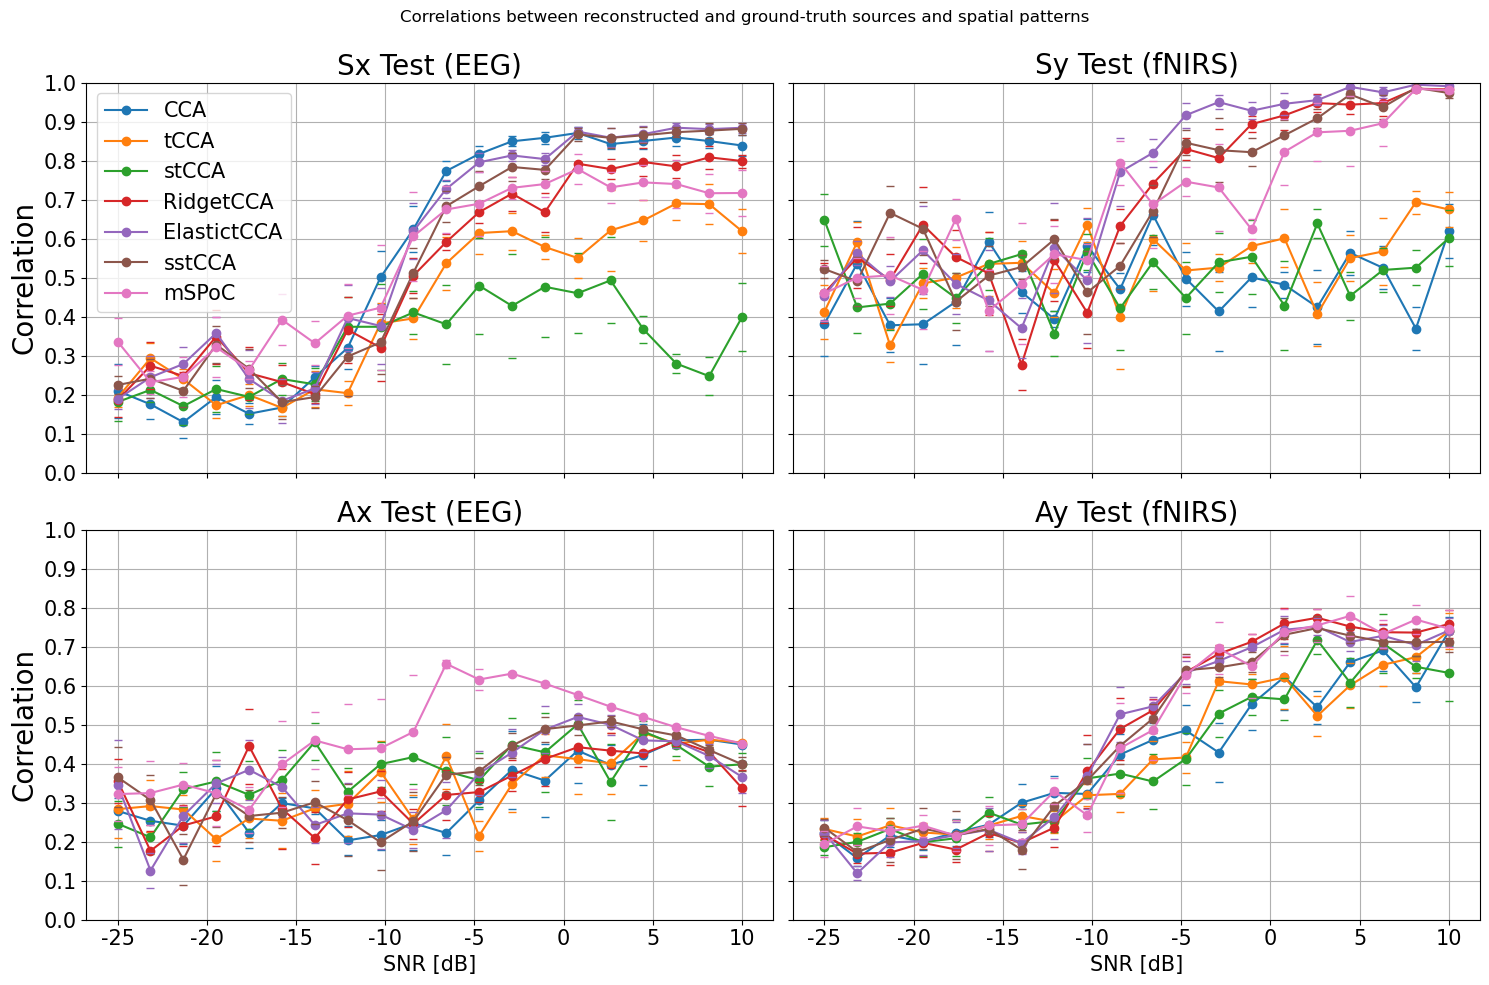

In [46]:
# Visualize simulation results

figsize=(15, 10)

colors = [c for c in mcolors.TABLEAU_COLORS.keys()]

fix, ax = plt.subplots(2, 2, figsize=figsize, sharex=True, sharey=True)

for j, (l1, corr) in enumerate(corr_dict.items()):
    # Compute mean and stds omitting nan values
    means, stds = fisher_z_stats(corr)
    non_nan_N = np.count_nonzero(~np.isnan(corr), axis=0)  # Number of simulations not cointaining NaN
    stds /= np.sqrt(non_nan_N)

    for i, l2 in enumerate(['Sx Test (EEG)', 'Sy Test (fNIRS)']):
        ax[0, i].plot(snr_list, means[:, 4+i], 'o-', color=colors[j], label=l1)
        ax[0, i].plot(snr_list, means[:, 4+i] + stds[:, 4+i], '_', color=colors[j])
        ax[0, i].plot(snr_list, means[:, 4+i] - stds[:, 4+i], '_', color=colors[j])
        ax[0, i].set_title(l2, fontsize=20)
    for i, l2 in enumerate(['Ax Test (EEG)', 'Ay Test (fNIRS)']):
        ax[1, i].plot(snr_list, means[:, 6+i], 'o-', color=colors[j], label=l1)
        ax[1, i].plot(snr_list, means[:, 6+i] + stds[:, 6+i], '_', color=colors[j])
        ax[1, i].plot(snr_list, means[:, 6+i] - stds[:, 6+i], '_', color=colors[j])
        ax[1, i].set_title(l2, fontsize=20)

for i in range(2):
    for j in range(2):
        ax[i, j].grid()
        ax[1, j].set_yticks(np.linspace(0, 1, 11))
        ax[i, j].set_ylim(0, 1)

ax[0, 0].legend(fontsize=15)
ax[1, 0].set_xlabel('SNR [dB]', fontsize=15)
ax[1, 0].set_xticklabels(np.arange(-30, 15, 5), fontsize=15)
ax[1, 1].set_xlabel('SNR [dB]', fontsize=15)
ax[1, 1].set_xticklabels(np.arange(-30, 15, 5), fontsize=15)
ax[0, 0].set_ylabel('Correlation', fontsize=20)
ax[0, 0].set_yticklabels(np.round(np.linspace(0, 1, 11), 1), fontsize=15)
ax[1, 0].set_yticklabels(np.round(np.linspace(0, 1, 11), 1), fontsize=15)
ax[1, 0].set_ylabel('Correlation', fontsize=20)
        
plt.suptitle('Correlations between reconstructed and ground-truth sources and spatial patterns\n')
plt.tight_layout()
plt.show()